In [93]:
import pandas as pd
import requests
from io import StringIO
import os
from dotenv import load_dotenv
import matplotlib.pyplot  as plt
import seaborn as sns
from datetime import date
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN



In [22]:
load_dotenv()

True

# Lectura y Preparación

In [23]:

#
myurl = os.environ["DETALLE_TAREAS_FULL_URL"] + "?" + os.environ["AZURE_DATALAKE_GENAI_TOKEN"]
df = pd.read_parquet(myurl)
#df = pd.read_parquet("data\\DETALLE_TAREAS_COMPLETO.parquet")
#df


In [24]:
df["FECHA_CIERRE"]=pd.to_datetime(df.FECHA_CIERRE,yearfirst=True,dayfirst=True)
df["DIA_SEMANA"]=df.FECHA_CIERRE.dt.day_of_week+1
df["DIA_SEMANA_NOM"]=df.FECHA_CIERRE.dt.day_name()
df["DIA_MES"]=df.FECHA_CIERRE.dt.days_in_month
df


FECHA_CIERRE CODIGO_TAREA      DESCRIPCION_TAREA              INICIO  \
0       2024-07-13     PX999C17  Depuracion del FSC017 2024-07-14 03:21:25   
1       2024-11-29     PX999C17  Depuracion del FSC017 2024-11-30 02:23:52   
2       2024-11-30     PX999C17  Depuracion del FSC017 2024-12-01 04:28:08   
3       2024-12-02     PX999C17  Depuracion del FSC017 2024-12-03 02:56:44   
4       2024-12-03     PX999C17  Depuracion del FSC017 2024-12-04 02:14:35   
...            ...          ...                    ...                 ...   
15573   2024-12-04    PCSMI001B        Rendicion Batch 2024-12-05 03:40:35   
15574   2024-12-05    PCSMI001B        Rendicion Batch 2024-12-06 03:52:17   
15575   2024-12-06    PCSMI001B        Rendicion Batch 2024-12-07 02:18:10   
15576   2024-12-07    PCSMI001B        Rendicion Batch 2024-12-08 01:30:58   
15577   2024-12-09    PCSMI001B        Rendicion Batch 2024-12-10 03:12:40   

                      FIN  DURACION_SEGUNDOS  DURACION  DIA_SEMANA  \
0     2024-07-14 03:21:26                1.0  00:00:01           6   
1     2024-11-30 02:23:53                1.0  00:00:01           5   
2     2024-12-01 04:28:09                1.0  00:00:01           6   
3     2024-12-03 02:56:45                1.0  00:00:01           1   
4     2024-12-04 02:14:36                1.0  00:00:01           2   
...                   ...                ...       ...         ...   
15573 2024-12-05 03:40:36                1.0  00:00:01           3   
15574 2024-12-06 03:52:18                1.0  00:00:01           4   
15575 2024-12-07 02:18:11                1.0  00:00:01           5   
15576 2024-12-08 01:31:00                2.0  00:00:02           6   
15577 2024-12-10 03:12:42                2.0  00:00:02           1   

      DIA_SEMANA_NOM  DIA_MES  
0           Saturday       31  
1             Friday       30  
2           Saturday       30  
3             Monday       31  
4            Tuesday       31  
...              ...      ...  
15573      Wednesday       31  
15574       Thursday       31  
15575         Friday       31  
15576       Saturday       31  
15577         Monday       31  

[15578 rows x 10 columns]

In [25]:
post_festivos=[
    date(2024,8,8)
    ,date(2024,8,20)
    ,date(2024,10,15)
    ,date(2024,11,5)
    ,date(2024,11,12)    
    ]

df["POST_FESTIVO"]=df.FECHA_CIERRE.isin(pd.to_datetime(post_festivos))


In [26]:
list_fin_mes = (pd.to_datetime('2024-08-31'),pd.to_datetime('2024-09-30'),pd.to_datetime('2024-10-31'))
fin_mes = df["FIN_MES"]=df.FECHA_CIERRE.isin(pd.to_datetime(list_fin_mes))


In [27]:
df["ID_TAREA"]=df.CODIGO_TAREA+"-"+df.DESCRIPCION_TAREA
df["DURACION_MIN"]=(df.DURACION_SEGUNDOS/60).round(0)
df["DURACION_HR"]=df.DURACION_SEGUNDOS/60/60
df["PAUSA"]=df.CODIGO_TAREA=="PAUSA"

In [28]:
df["PAUSA"].value_counts()


PAUSA
False    14960
True       618
Name: count, dtype: int64

# Análisis

## Duración total

### Distribución

In [34]:
df.groupby(["FECHA_CIERRE"], as_index=False,)["DURACION_MIN"].agg(["max","min","mean","median","sum"]	).sort_values("sum",ascending=False)

FECHA_CIERRE    max  min      mean  median    sum
14    2024-07-31  111.0  0.0  4.762500     1.0  762.0
10    2024-07-26  203.0  0.0  5.503817     0.0  721.0
19    2024-08-06  180.0  0.0  4.559055     0.0  579.0
70    2024-10-07  106.0  0.0  4.285714     0.0  540.0
93    2024-11-05  110.0  0.0  4.095238     0.0  516.0
..           ...    ...  ...       ...     ...    ...
63    2024-09-28   37.0  0.0  2.440945     0.0  310.0
120   2024-12-07   34.0  0.0  2.452381     0.0  309.0
97    2024-11-09   29.0  0.0  2.373016     0.0  299.0
101   2024-11-15   31.0  0.0  2.365079     0.0  298.0
0     2024-07-13   32.0  0.0  2.530864     0.0  205.0

[122 rows x 6 columns]

array([[<Axes: title={'center': 'sum'}>]], dtype=object)

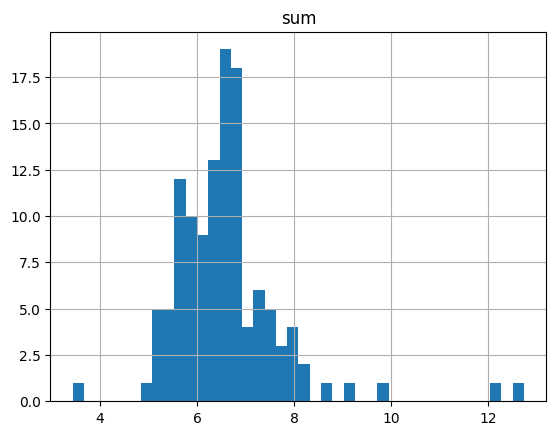

In [35]:
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).hist(bins=40)

<Axes: >

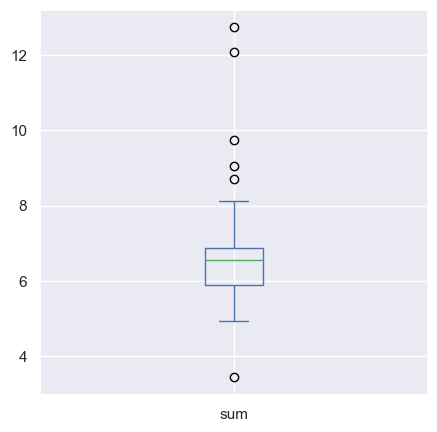

In [36]:
sns.set_theme(rc={'figure.figsize':(5,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

<Axes: xlabel='FECHA_CIERRE'>

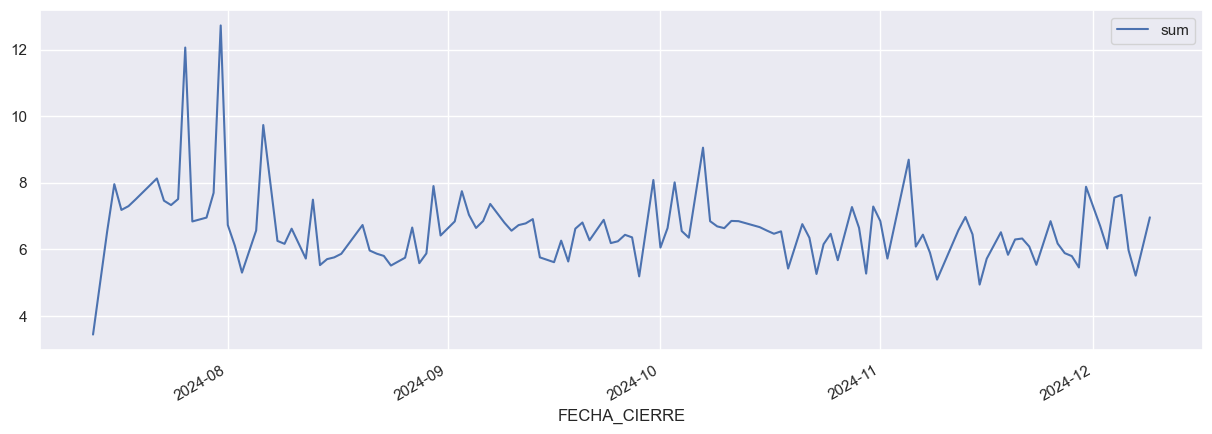

In [37]:
sns.set_theme(rc={'figure.figsize':(15,5)})
df.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot()

Conclusion. Distribución de cola derecha con valores extremos (anomalias) por encima de 500

<Axes: >

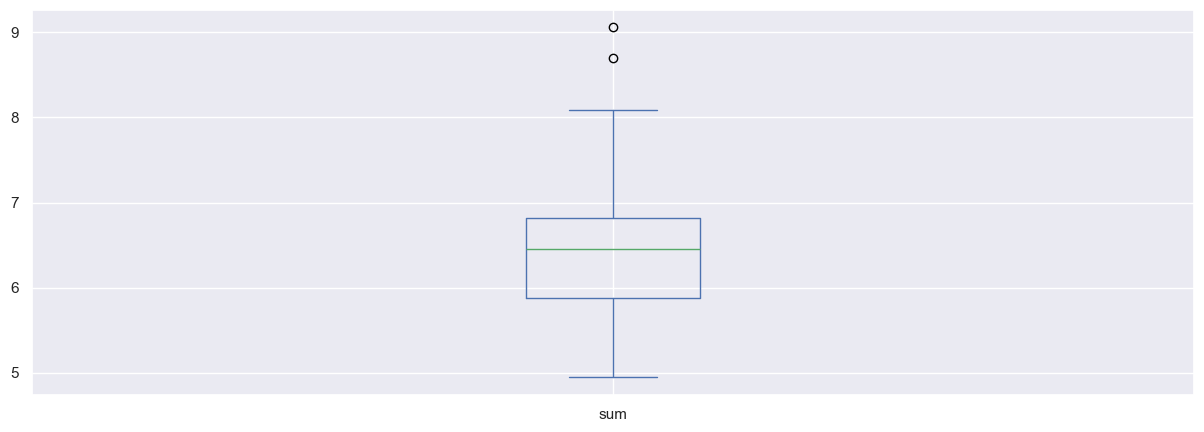

In [38]:
df_parcial=df.query("FECHA_CIERRE >= '2024-08-15'")
df_parcial.groupby(["FECHA_CIERRE"], )["DURACION_HR"].agg(["sum"]	).plot.box()

## Pausas

In [39]:
df_sum=df_parcial.groupby("FECHA_CIERRE", as_index=True)["DURACION_MIN"].agg(["max","sum"])
df_sum.rename(columns={"max":"TAREA_MAX","sum":"TOTAL"}, inplace=True)
df_sum_pausas=df_parcial[df_parcial.PAUSA].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_sum_pausas.set_index("FECHA_CIERRE", inplace=True)
df_sum_pausas.rename(columns={"DURACION_MIN":"DURACION_PAUSAS"},inplace=True)
df_sum=df_sum.join(df_sum_pausas,)
df_sum["SIN_PAUSA"]=df_sum.TOTAL - df_sum.DURACION_PAUSAS


<Axes: xlabel='FECHA_CIERRE'>

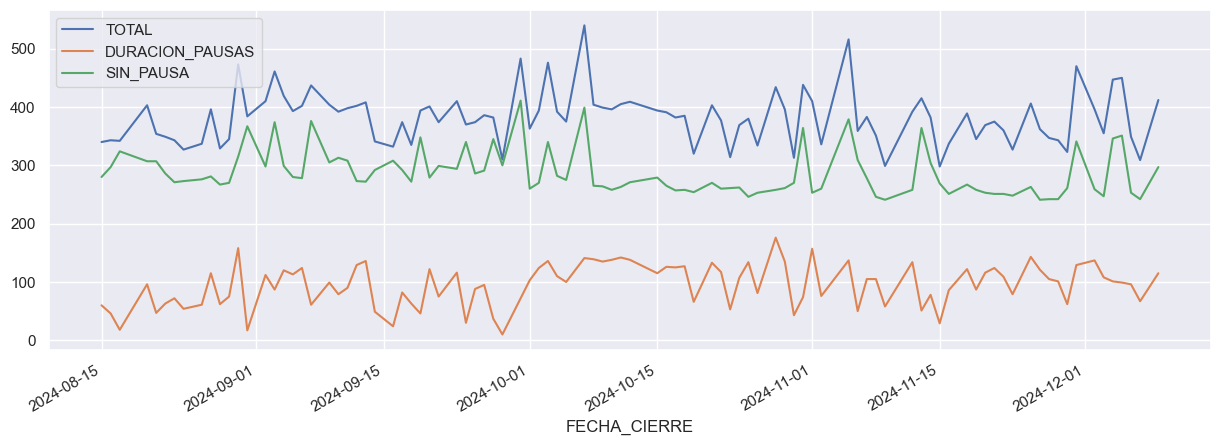

In [40]:
df_sum[['TOTAL','DURACION_PAUSAS','SIN_PAUSA']].plot(subplots=False)

Los datos antes del mes 9 tienen picos y no todos estaban asociados a pausas

<Axes: xlabel='FECHA_CIERRE'>

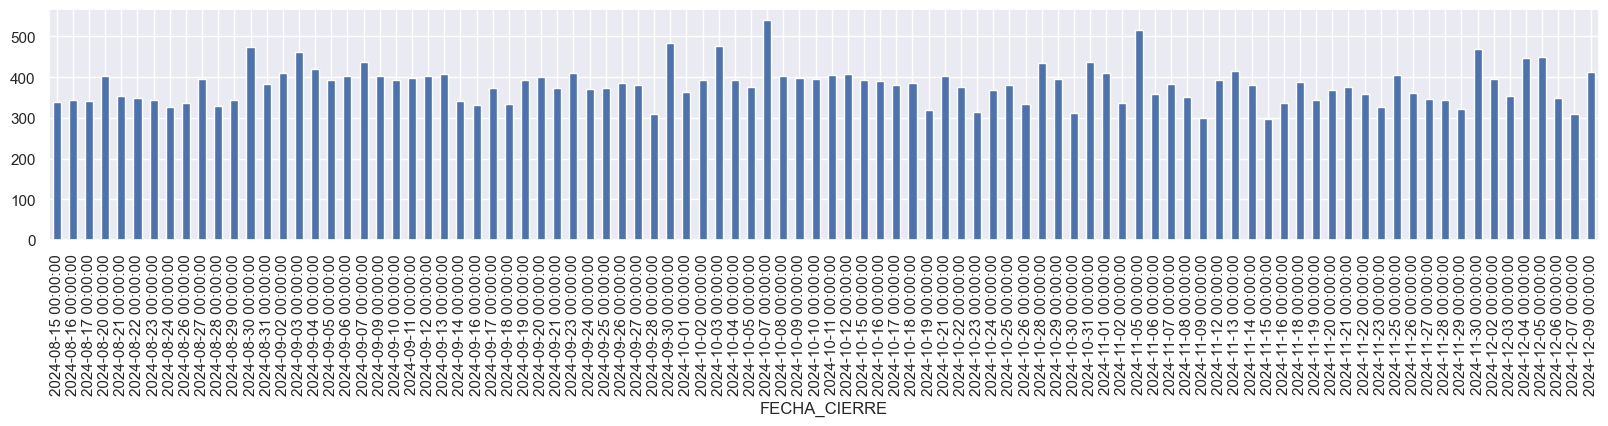

In [41]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_sum.query("index >= '2024-08-15' ")["TOTAL"].plot.bar()

<Axes: xlabel='FECHA_CIERRE'>

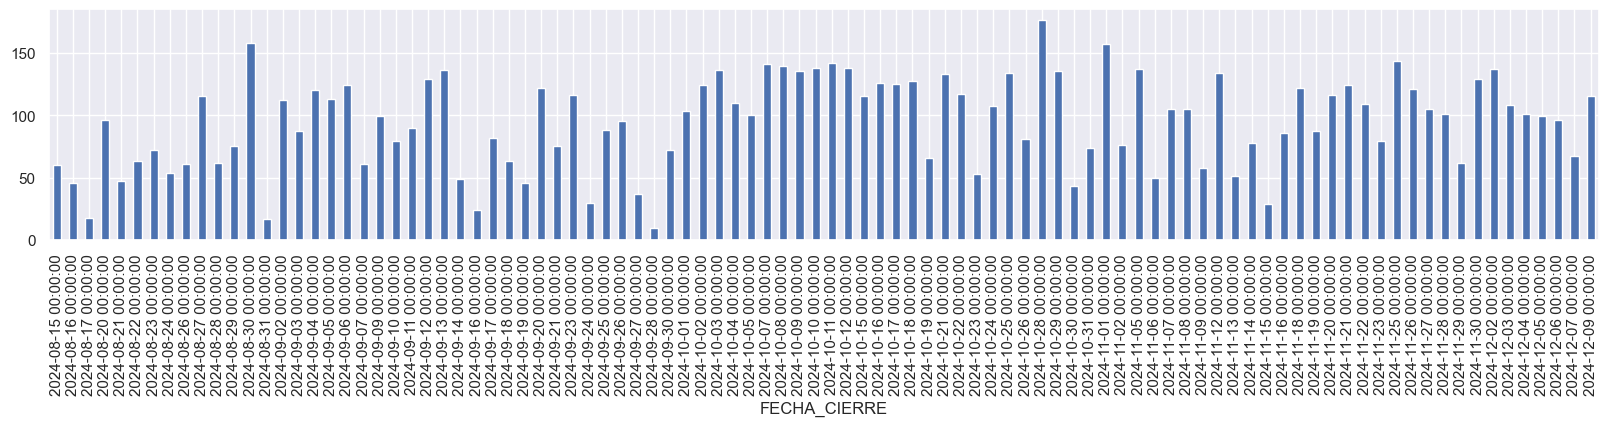

In [42]:
df_sum["DURACION_PAUSAS"].plot.bar()


<Axes: >

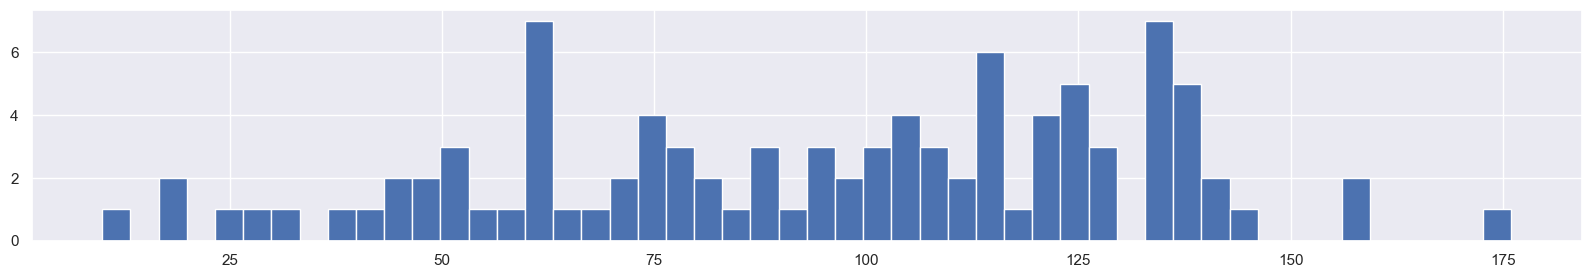

In [43]:
df_sum["DURACION_PAUSAS"].hist(bins=50)

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose


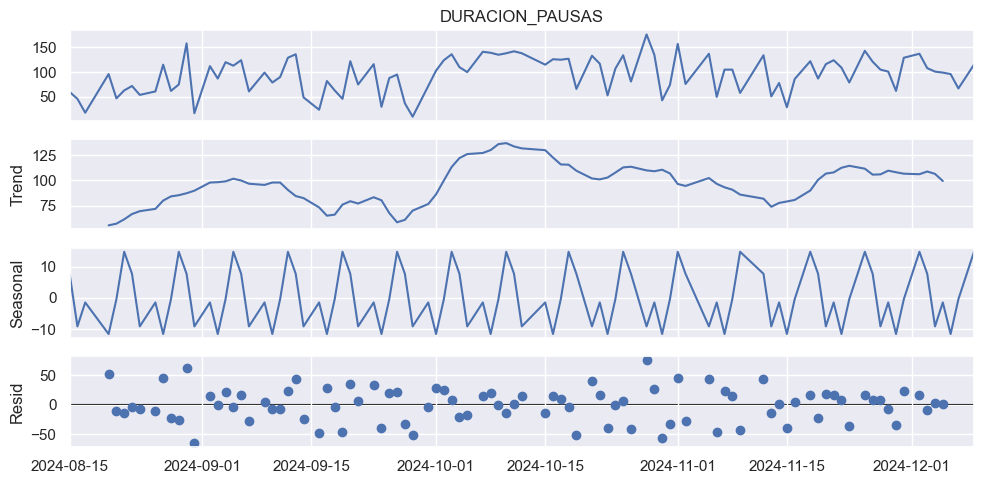

In [45]:
sns.set_theme(rc={'figure.figsize':(10,5)})
decompose_result_mult = seasonal_decompose(df_sum["DURACION_PAUSAS"], model="additive", period=6)

decompose_result_mult.plot();

In [46]:
df_sum["FECHA"]=df_sum.index
df_sum["POST_FESTIVO"]=df_sum.FECHA.isin(pd.to_datetime(post_festivos))
df_sum["FIN_MES"]=df_sum.FECHA.isin(pd.to_datetime(list_fin_mes))

In [47]:
df_sum["ETIQUETA"]="NORMAL"
df_sum.loc[df_sum.POST_FESTIVO,"ETIQUETA"] =   'post festivo'
df_sum.loc[df_sum.FIN_MES,"ETIQUETA"]=   'fin mes'


df_sum[df_sum["ETIQUETA"] > "NORMAL"]


TAREA_MAX  TOTAL  DURACION_PAUSAS  SIN_PAUSA      FECHA  \
FECHA_CIERRE                                                            
2024-08-20         86.0  403.0             96.0      307.0 2024-08-20   
2024-08-31         37.0  384.0             17.0      367.0 2024-08-31   
2024-09-30         63.0  483.0             72.0      411.0 2024-09-30   
2024-10-15         96.0  394.0            115.0      279.0 2024-10-15   
2024-10-31         64.0  438.0             74.0      364.0 2024-10-31   
2024-11-05        110.0  516.0            137.0      379.0 2024-11-05   
2024-11-12         95.0  392.0            134.0      258.0 2024-11-12   

              POST_FESTIVO  FIN_MES      ETIQUETA  
FECHA_CIERRE                                       
2024-08-20            True    False  post festivo  
2024-08-31           False     True       fin mes  
2024-09-30           False     True       fin mes  
2024-10-15            True    False  post festivo  
2024-10-31           False     True       fin mes  
2024-11-05            True    False  post festivo  
2024-11-12            True    False  post festivo

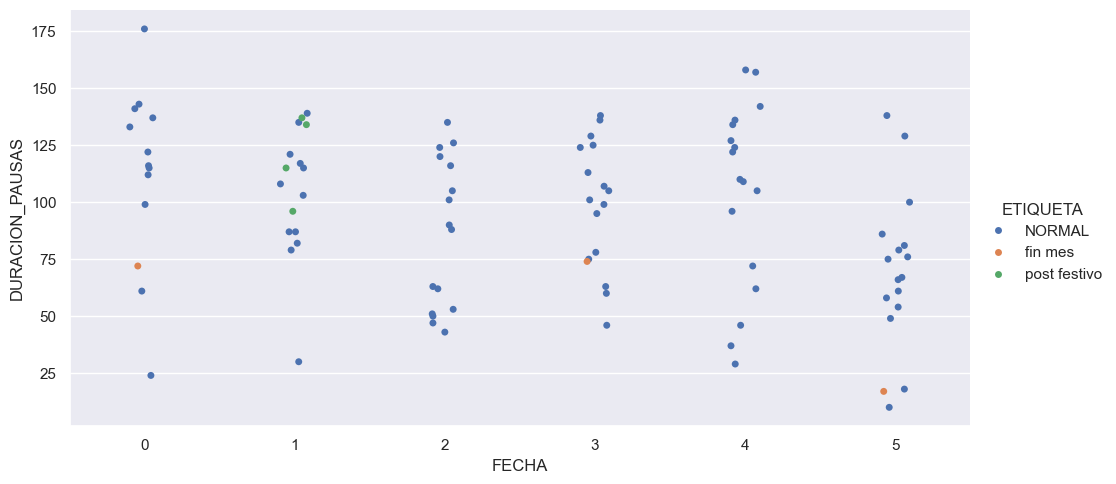

In [48]:
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["DURACION_PAUSAS"], hue=df_sum.ETIQUETA,  aspect=2)

### Conclusión
- Existe un patron en las pausas y no se precia correlación en la duración de las otras tareas. El patrón está relacionado con los días de la semana pero los valores extremos impide que sea concluyente.
- Existen valores extremos que se pueden atribuir a las pausas y otros valores relacionados con otra tareas


## Sin pausas
- ¿El patrón de comportamiento de las tareas está relacionado con la semana o mes?

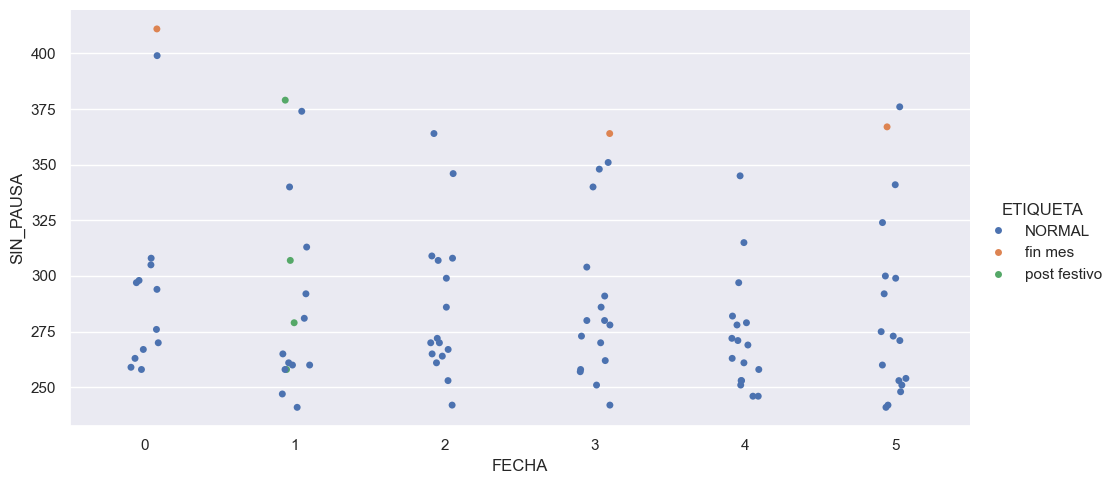

In [49]:
sns.set_theme(rc={'figure.figsize':(8,3)})
g=sns.catplot(x=df_sum["FECHA"].dt.day_of_week, y=df_sum["SIN_PAUSA"], hue=df_sum.ETIQUETA,  aspect=2)

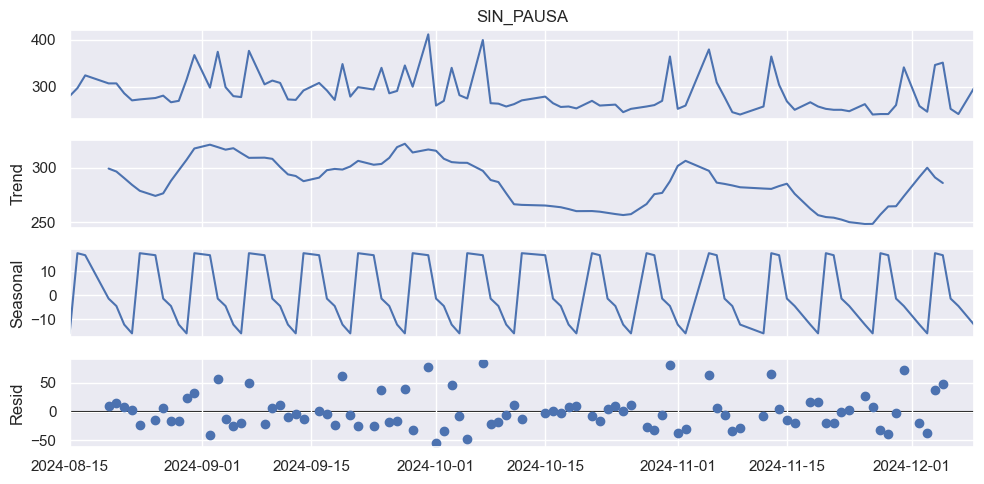

In [50]:
sns.set_theme(rc={'figure.figsize':(10,5)})
decompose_result_mult = seasonal_decompose(df_sum["SIN_PAUSA"], model="additive", period=6)

decompose_result_mult.plot();

### Notas
- La variación en las tareas sin pausas también es alta.
- También se ve un leve patrón por los días de la semana pero los valores extremos superiores impiden caputurarlo en un modelo.
- Los días festivos no parecen afectar la duración de las tareas sin pausas
- Los finales de mes están asociados a duraciones altas

## Tareas representativas

- ¿Las tareas de mayor duración explican la variación?
- ¿Existe un comportamiento similar entre un grupo de tareas (aumentan o disminuyen al mismo tiempo)?


### Top tareas minutos totales

In [51]:
df_tareas_agg=df_parcial.groupby(["CODIGO_TAREA"], as_index=True,)["DURACION_MIN"].agg(["max","min","mean","median","count","sum"]	).sort_values("sum",ascending=False)


In [52]:
df_agg_top=df_tareas_agg.sort_values("sum",ascending=False).head(10)
df_agg_top

max   min       mean  median  count     sum
CODIGO_TAREA                                               
PAUSA         129.0   0.0  18.779381     4.0    485  9108.0
PBCGD017       42.0  27.0  33.729167    33.5     96  3238.0
PSNG9122       21.0  17.0  18.666667    18.5     96  1792.0
PJBWM077       22.0  13.0  17.406250    18.0     96  1671.0
PNU00217       32.0   7.0  16.895833    16.5     96  1622.0
PP017          30.0  12.0  16.520833    16.5     96  1586.0
PNU00002       22.0   9.0  14.812500    16.0     96  1422.0
PCC00003       26.0  11.0  14.343750    14.0     96  1377.0
PPP92005       45.0   9.0  13.895833    14.0     96  1334.0
PJBWM010       12.0   6.0   9.479167    10.0     96   910.0

In [53]:
lst_top=df_agg_top.index.to_list()


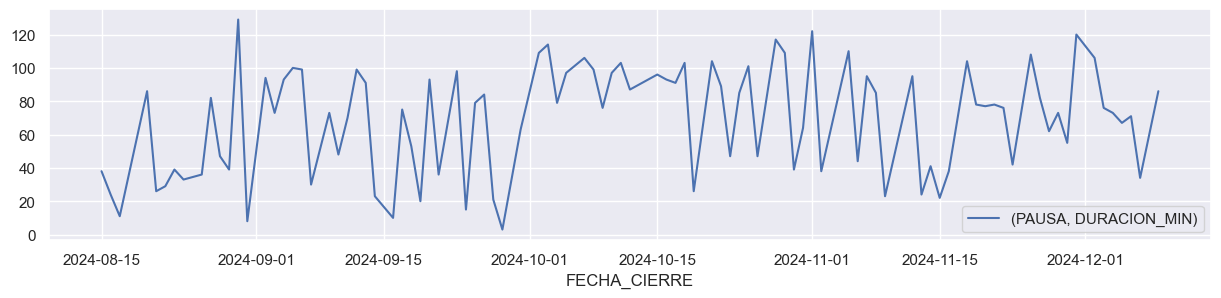

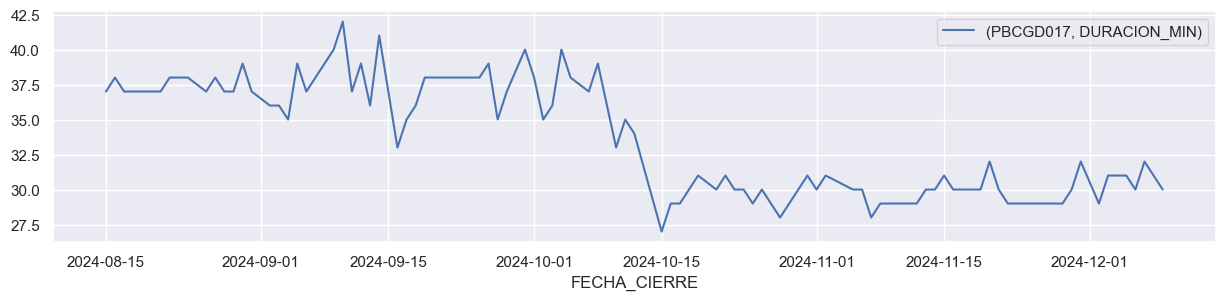

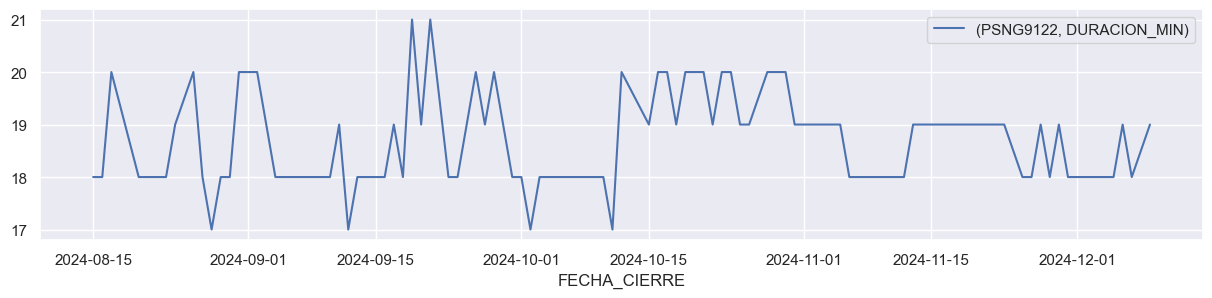

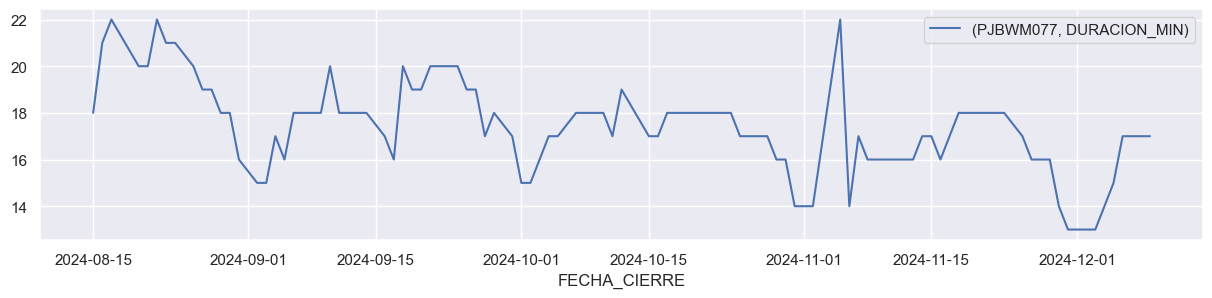

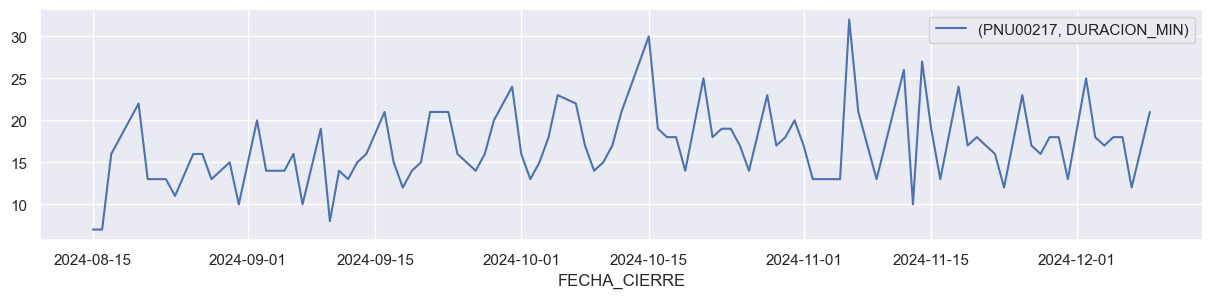

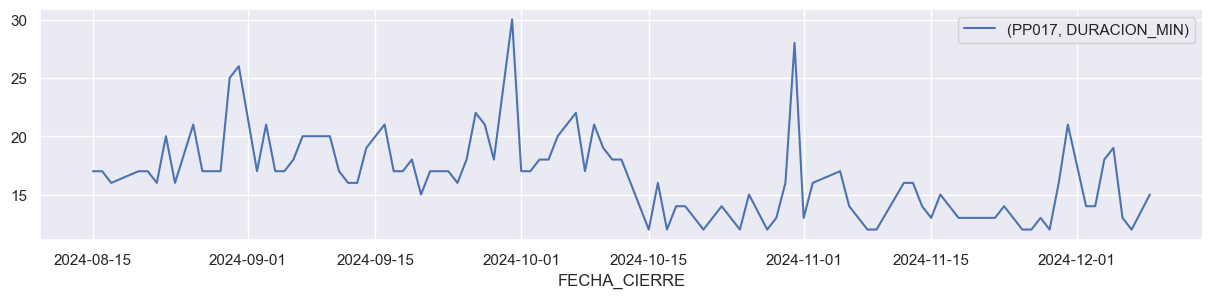

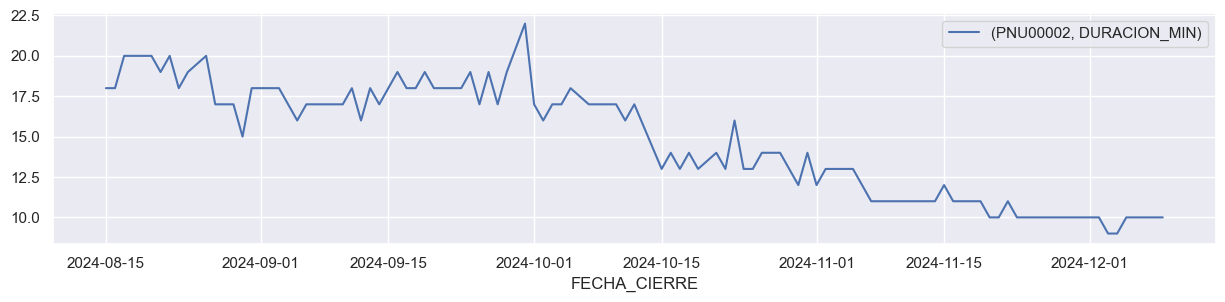

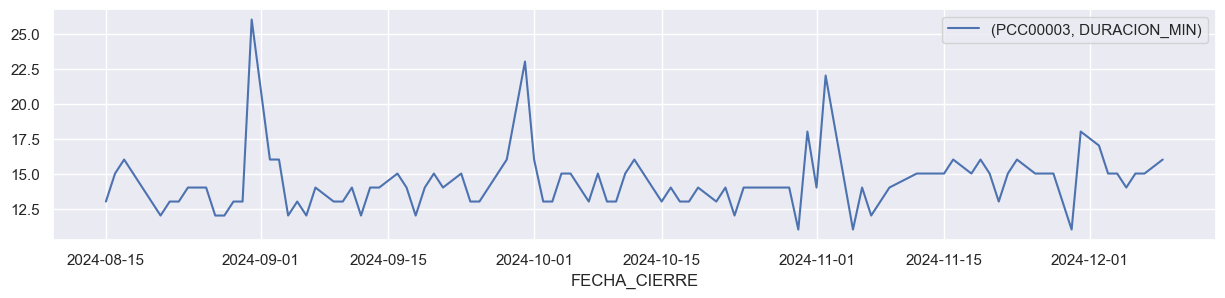

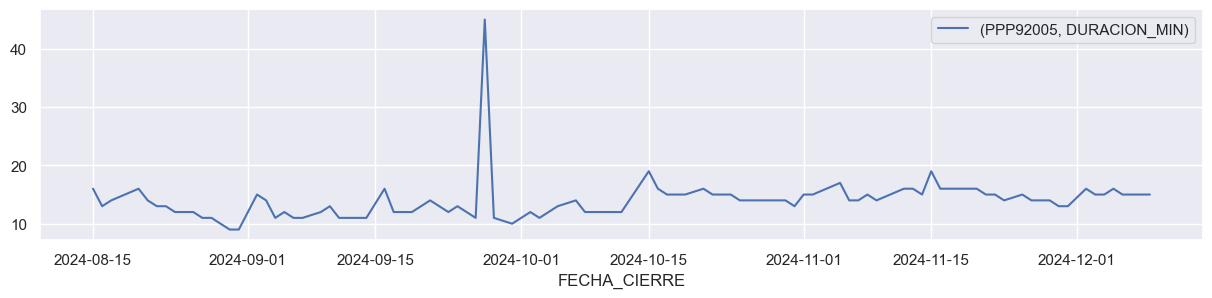

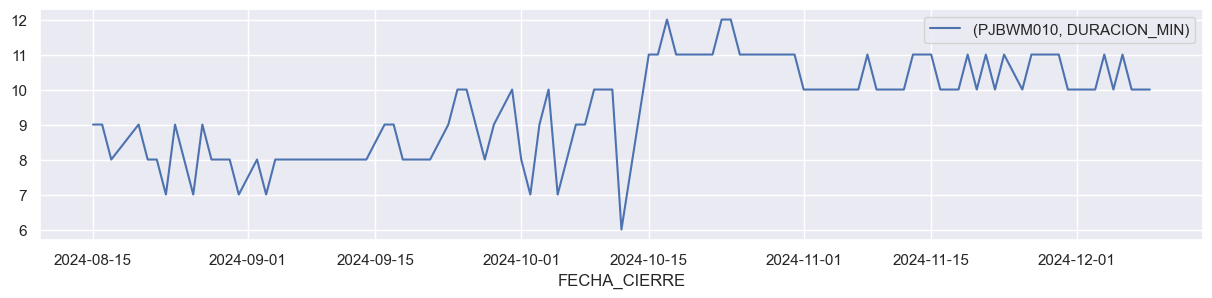

In [54]:
sns.set_theme(rc={'figure.figsize':(15,3)})
for tarea in df_tareas_agg.sort_values("sum",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Ordenados por máximo

In [55]:
df_tareas_agg.sort_values("max",ascending=False).head(15)

max   min       mean  median  count     sum
CODIGO_TAREA                                               
PAUSA         129.0   0.0  18.779381     4.0    485  9108.0
PAHP900        66.0   0.0   0.687500     0.0     96    66.0
PP020FV2       59.0   1.0   5.968750     1.0     96   573.0
PNU00009       46.0   3.0   6.010417     5.0     96   577.0
PPP92005       45.0   9.0  13.895833    14.0     96  1334.0
PB098100       45.0   2.0  20.461538    18.0     39   798.0
PBCGD017       42.0  27.0  33.729167    33.5     96  3238.0
PP020A         40.0   3.0   7.770833     5.0     96   746.0
PNU00117       33.0   1.0   2.406250     1.0     96   231.0
PNU00217       32.0   7.0  16.895833    16.5     96  1622.0
PSNG917        31.0   6.0   7.468750     8.0     96   717.0
PP017          30.0  12.0  16.520833    16.5     96  1586.0
PBCGD011       28.0   1.0   3.208333     1.0     96   308.0
PCC00003       26.0  11.0  14.343750    14.0     96  1377.0
PJBWM077       22.0  13.0  17.406250    18.0     96  1671.0

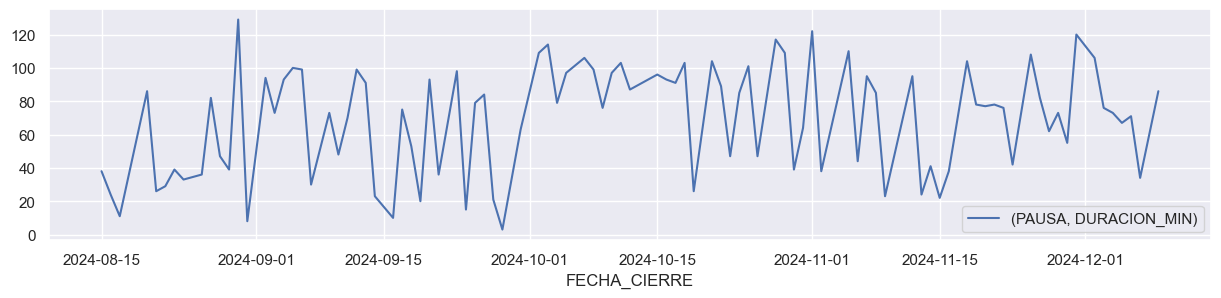

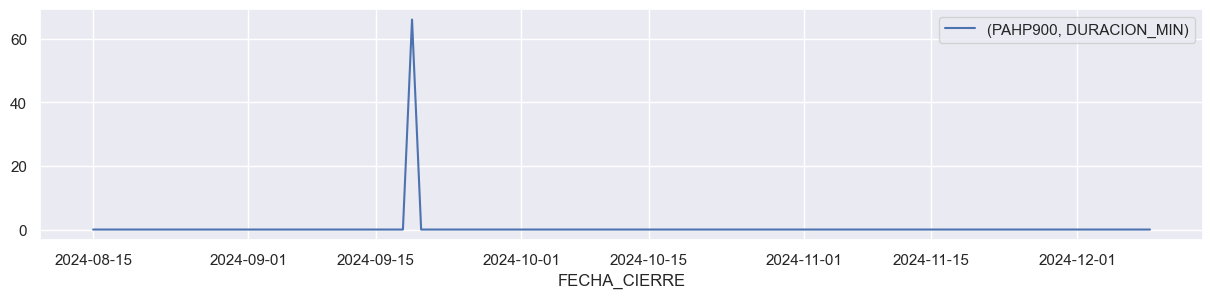

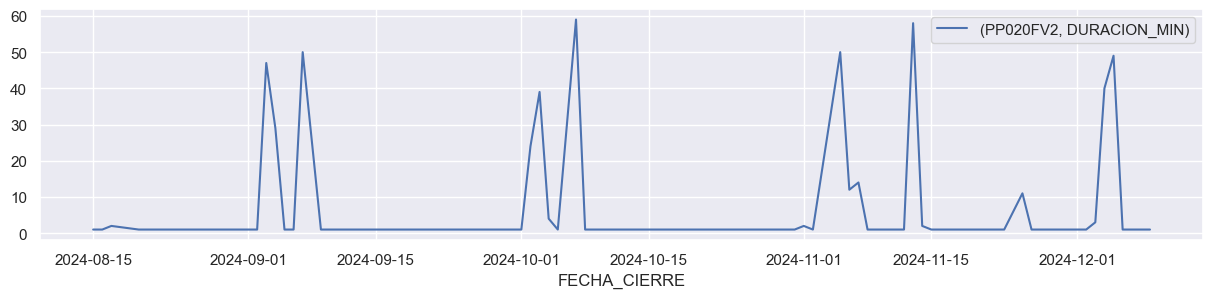

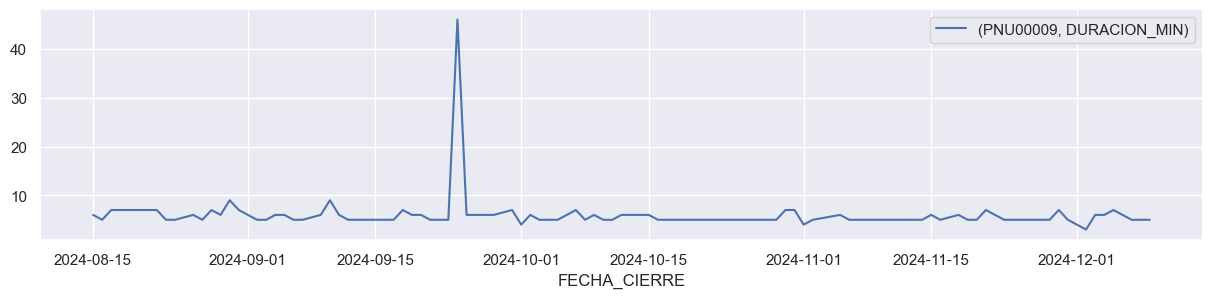

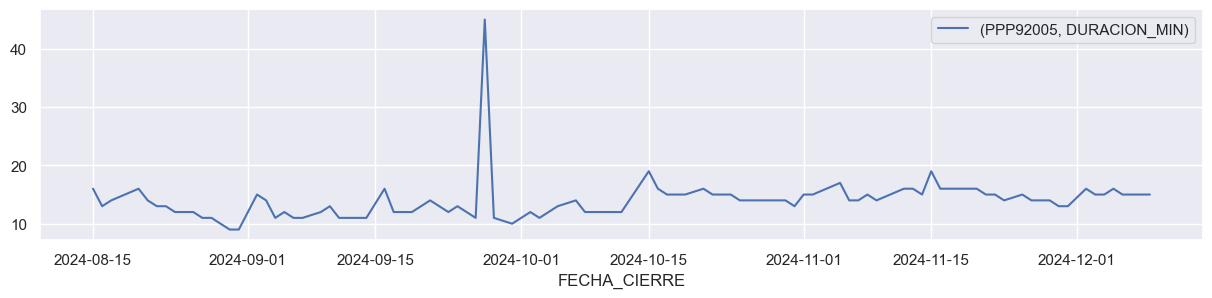

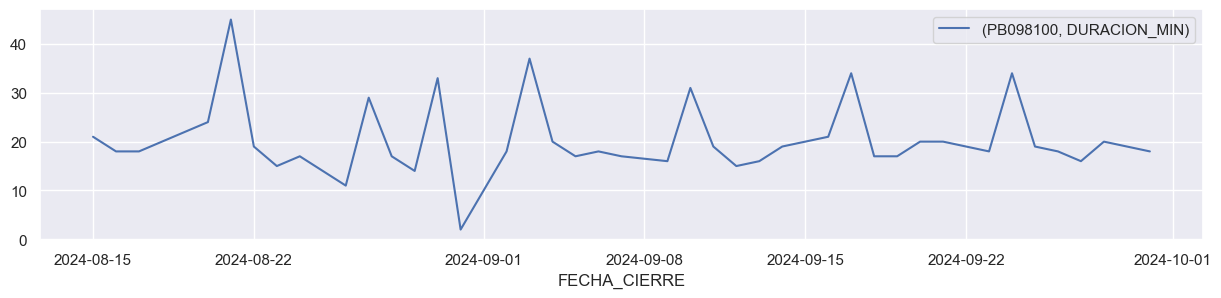

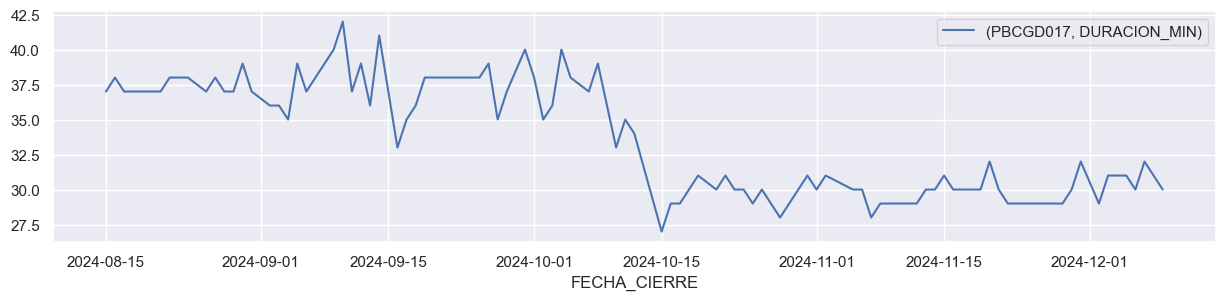

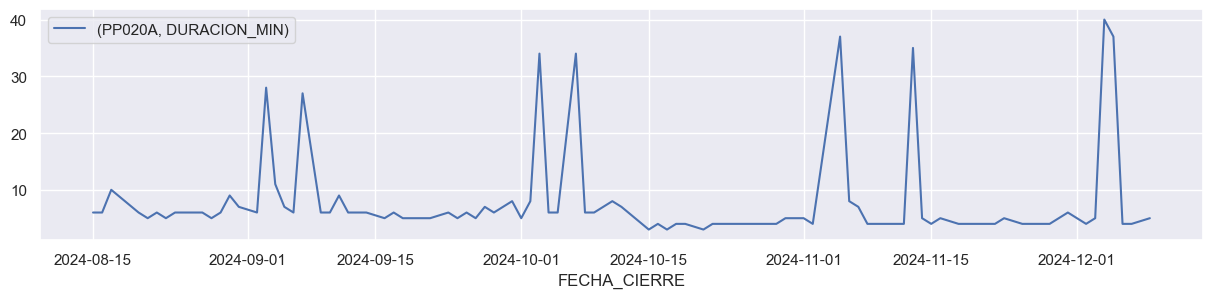

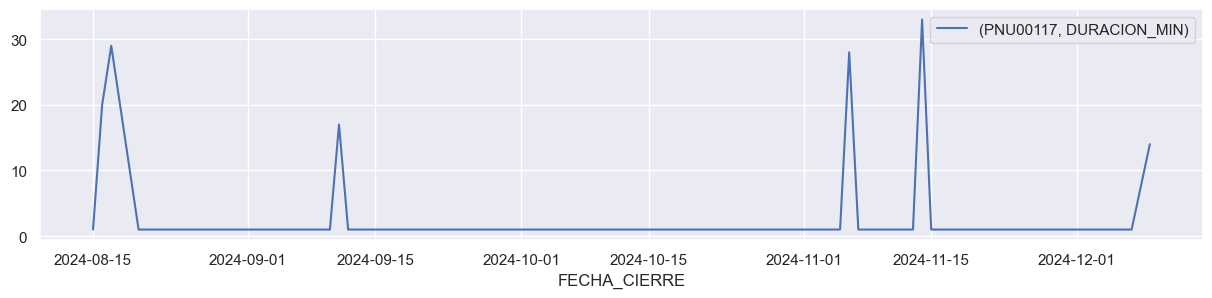

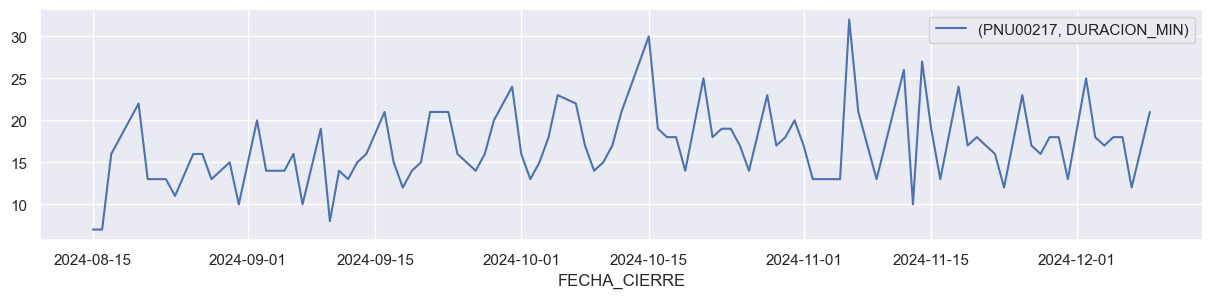

In [56]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")
    

### Correlacion

In [57]:
df_tareas_agg.groupby("max").size()

max
0.0      66
1.0      23
2.0      13
3.0       4
4.0       6
5.0       4
6.0       4
8.0       2
9.0       3
10.0      4
12.0      2
13.0      1
15.0      1
21.0      1
22.0      3
26.0      1
28.0      1
30.0      1
31.0      1
32.0      1
33.0      1
40.0      1
42.0      1
45.0      2
46.0      1
59.0      1
66.0      1
129.0     1
dtype: int64

<Axes: xlabel='max'>

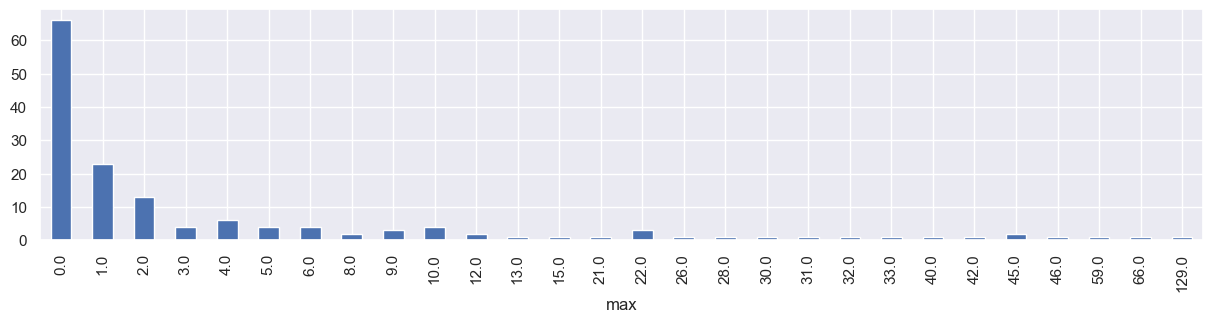

In [58]:
df_tareas_agg.groupby("max").size().plot.bar()


In [59]:
tareas_max5=df_tareas_agg[df_tareas_agg["max"]>5].index
tareas_max5
df_tareas_max5=df_parcial[df_parcial.CODIGO_TAREA.isin(tareas_max5)]

In [60]:
crosstab_df = pd.crosstab(df_tareas_max5['FECHA_CIERRE'], df_tareas_max5['CODIGO_TAREA'], values=df['DURACION_MIN'], aggfunc='sum').fillna(0)
crosstab_df.loc[:,"TOTAL"] = crosstab_df.sum(axis=1)
correlation_matrix = crosstab_df.corr()

<Axes: xlabel='CODIGO_TAREA', ylabel='CODIGO_TAREA'>

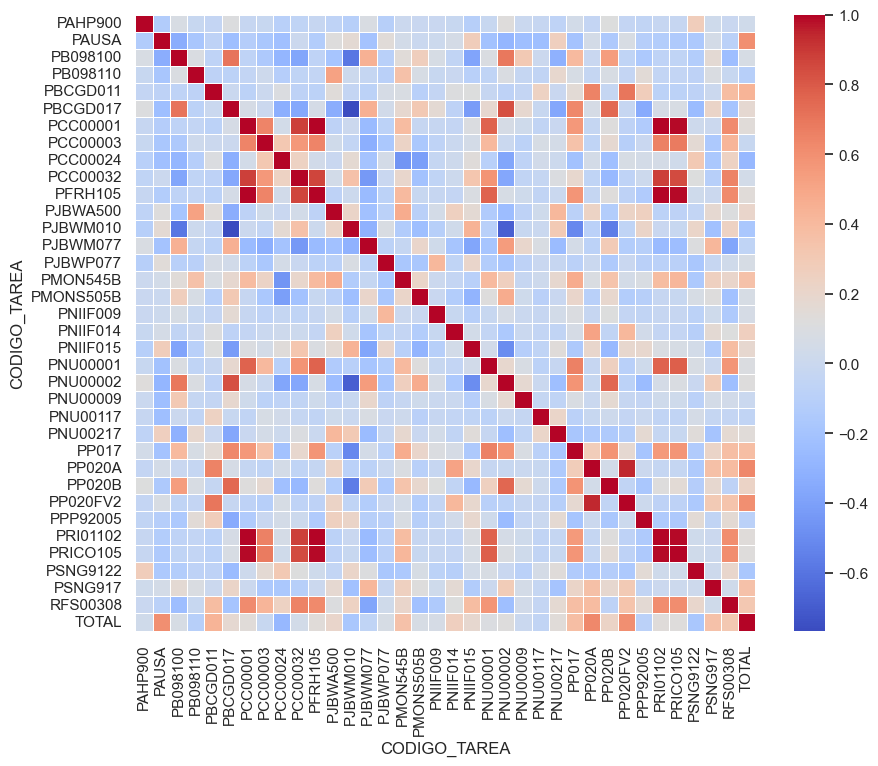

In [61]:

sns.set_theme(rc={'figure.figsize':(10,8)})

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)

In [62]:
lst_seleccion=['PCC00001','PRICO105','PRI01102','PFRH105']
crosstab_df[lst_seleccion][crosstab_df.PCC00001>0]

CODIGO_TAREA  PCC00001  PRICO105  PRI01102  PFRH105
FECHA_CIERRE                                       
2024-08-31        11.0       9.0       6.0     12.0
2024-09-30        11.0       8.0       5.0     12.0
2024-10-31        11.0       7.0       5.0     13.0
2024-11-30        12.0       7.0       6.0     12.0

In [63]:
list_fin_mes = (pd.to_datetime('2024-08-31'),pd.to_datetime('2024-09-30'),pd.to_datetime('2024-10-31'))

<Axes: xlabel='FECHA_CIERRE'>

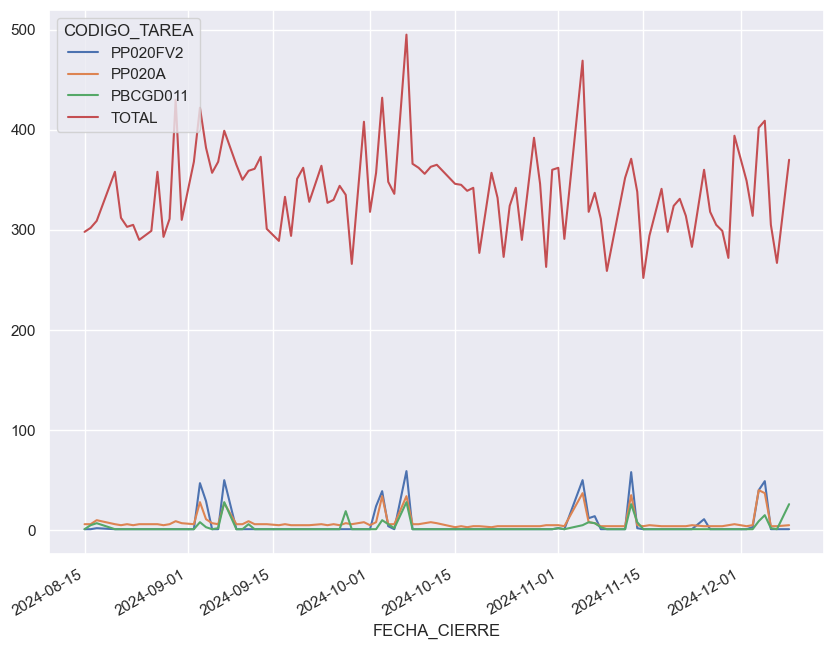

In [64]:
lst_seleccion=['PP020FV2','PP020A','PBCGD011',"TOTAL"]
crosstab_df[lst_seleccion].dropna(thresh=1).plot()
#for tarea in lst_seleccion:
#    df_parcial[df_parcial["CODIGO_TAREA"]==tarea].groupby("FECHA_CIERRE")[["CODIGO_TAREA","DURACION_MIN"]].max().plot(by="CODIGO_TAREA")


### NOTAS
Para el análisis de correlación se tomaron las tareas que han tenido tiempos máximos mayores a 5 minutos
se identificó que:
- las tareas 'PCC00001','PRICO105','PRI01102' estan relacionadas entre ellas porque se ejecutan al final de cada mes pero la duración es muy baja
- Las tareas tienen semejanza en los días de valores máximos 'PP020FV2','PP020A','PBCGD011' y parecen relacionados con la duraciones máximas de todo el proceso


### Agrupar tareas por comportamiento

In [65]:
df_crosstab_completo = pd.crosstab(df_parcial['CODIGO_TAREA'], df_parcial['FECHA_CIERRE'], values=df['DURACION_MIN'], aggfunc='sum').reset_index()
df_crosstab_completo.fillna(0,inplace=True) 
scaler = StandardScaler()
duraciones_normalizadas = scaler.fit_transform(df_crosstab_completo.iloc[:, 1:])


In [66]:
dbscan = DBSCAN(eps=.2, min_samples=3) 
clusters=dbscan.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters

In [67]:
df_crosstab_completo.groupby("GRUPO").size() [df_crosstab_completo.groupby("GRUPO").size() > 1]

GRUPO
-1    61
 0    69
 1     6
 2    12
 3     3
dtype: int64

In [68]:
sns.set_theme(rc={'figure.figsize':(20,3)})
df_crosstab_completo.set_index('CODIGO_TAREA', inplace=True)


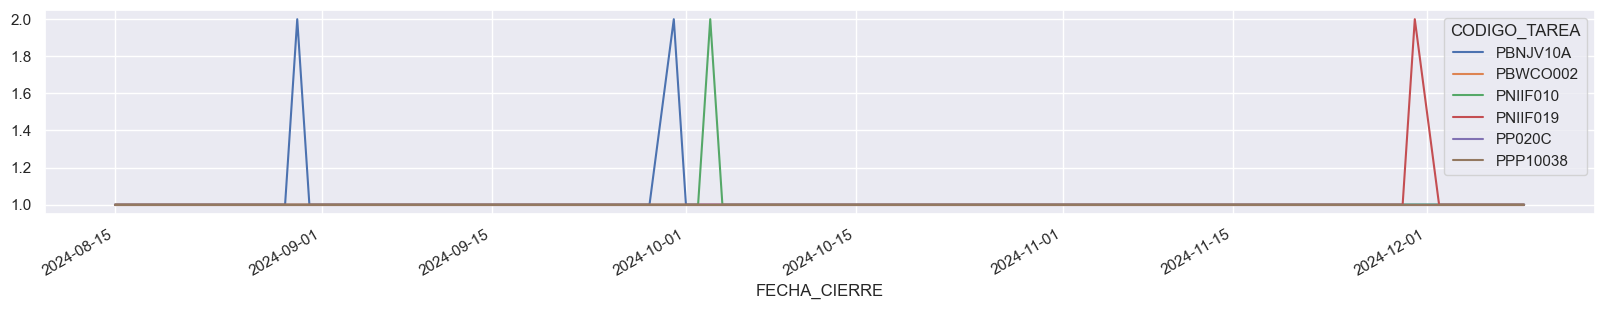

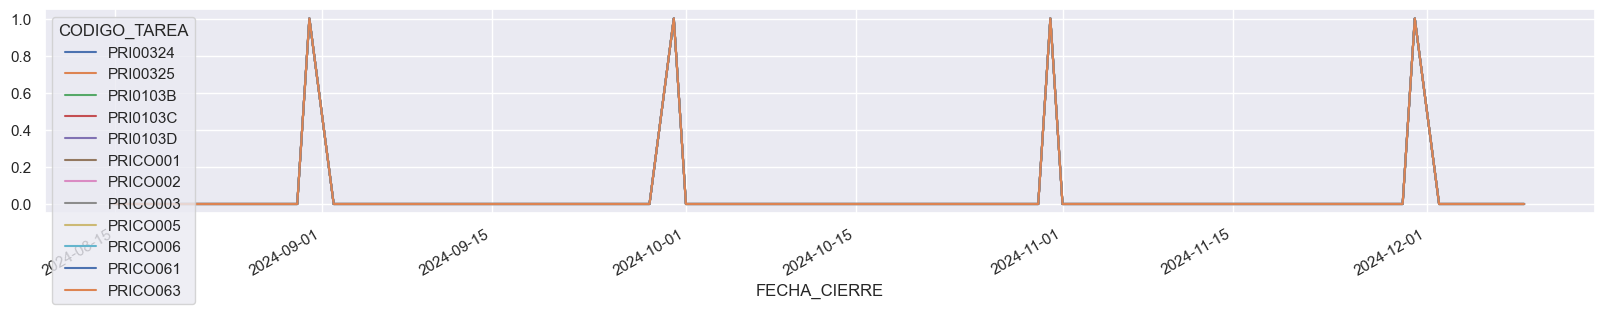

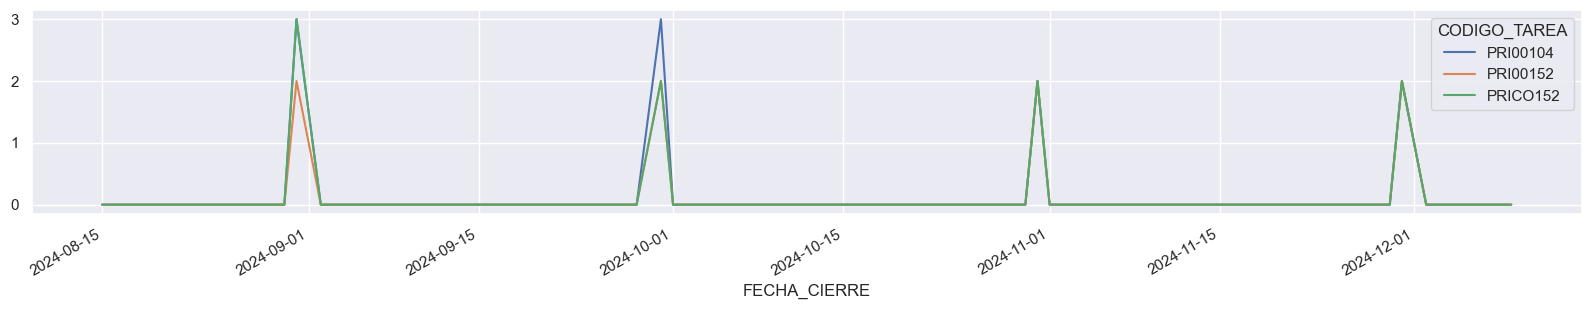

In [69]:
for grupo in [1,2,3]:
   (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


In [70]:
# Seleccionar un número de clusters y aplicar K-means
kmeans = KMeans(n_clusters=7, random_state=42)  # Cambiar el número según el método del codo
clusters = kmeans.fit_predict(duraciones_normalizadas)
df_crosstab_completo["GRUPO"]=clusters
df_crosstab_completo.groupby("GRUPO").size()
#df_crosstab_completo.set_index('CODIGO_TAREA',inplace=True)


GRUPO
0      3
1    125
2      1
3      1
4      6
5      1
6     14
dtype: int64

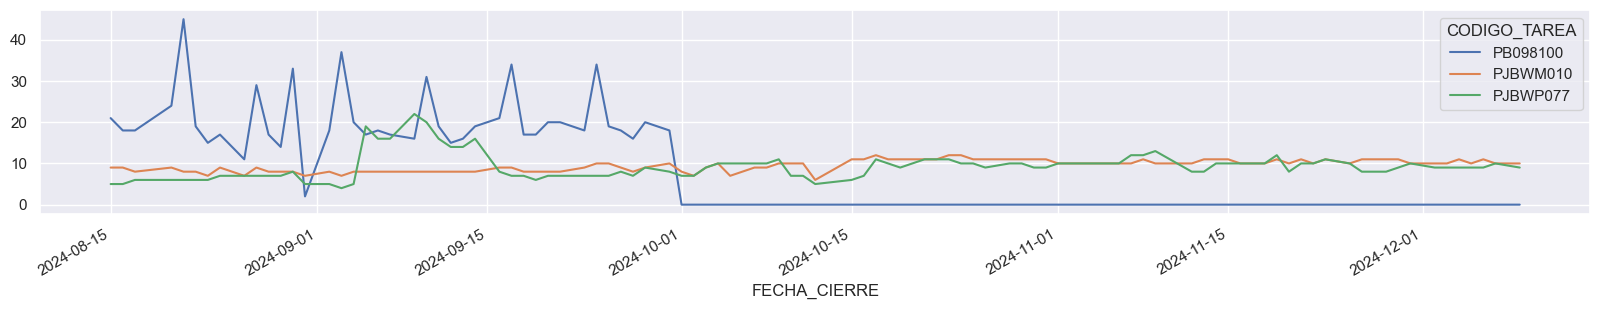

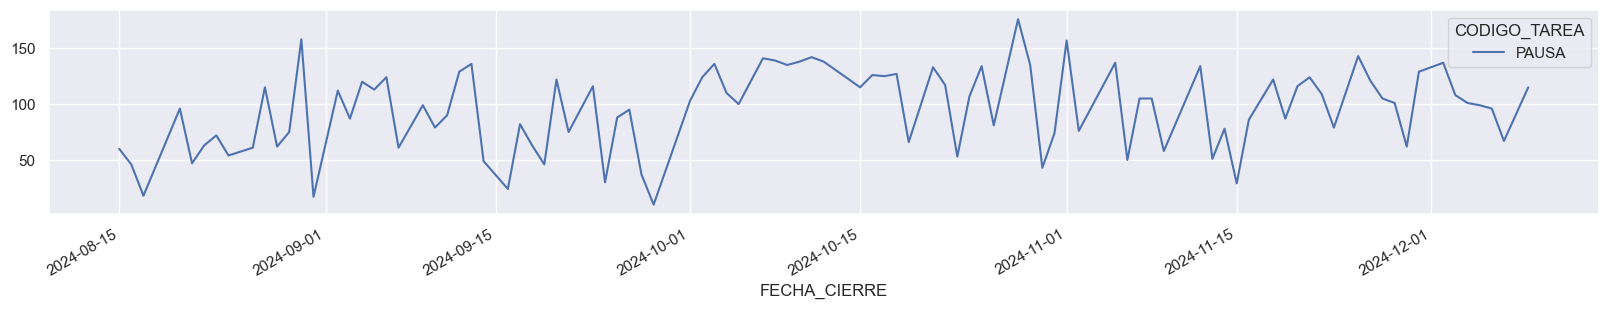

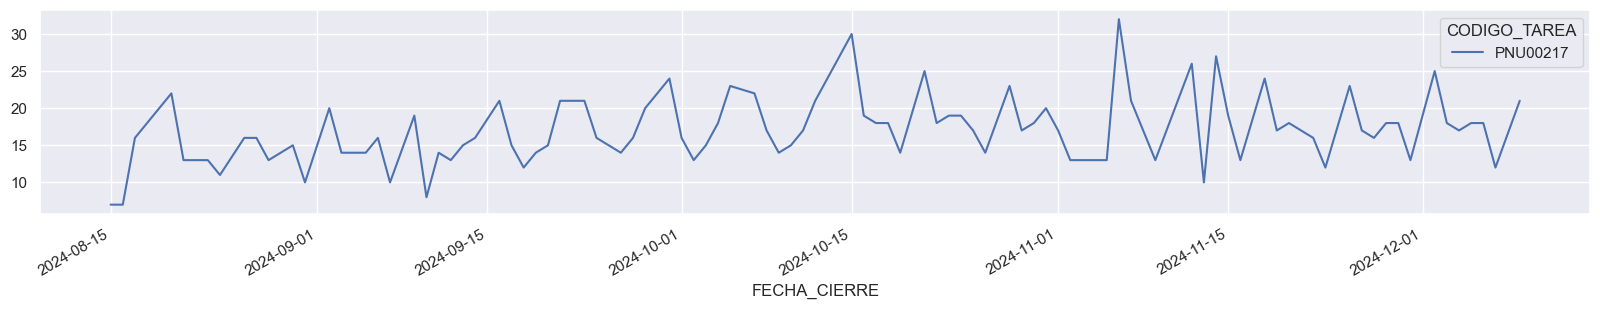

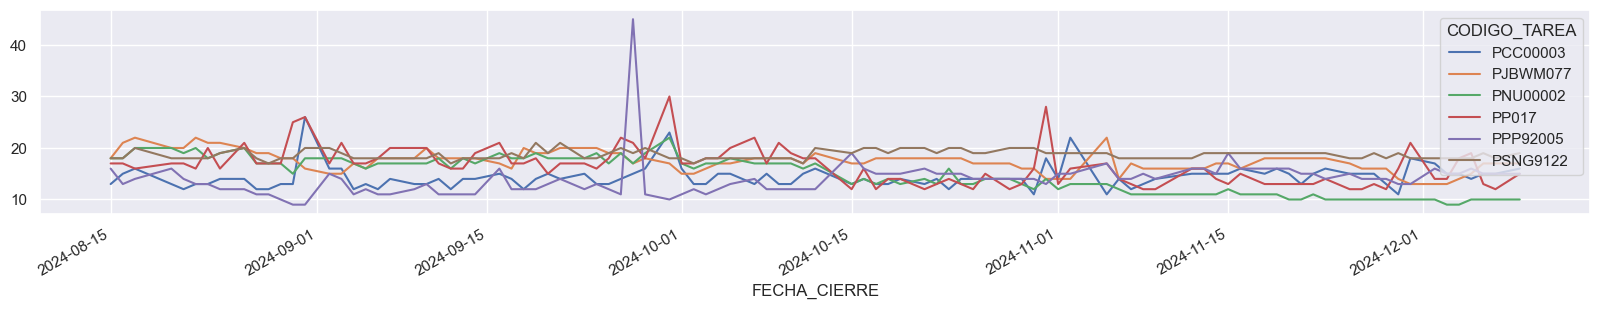

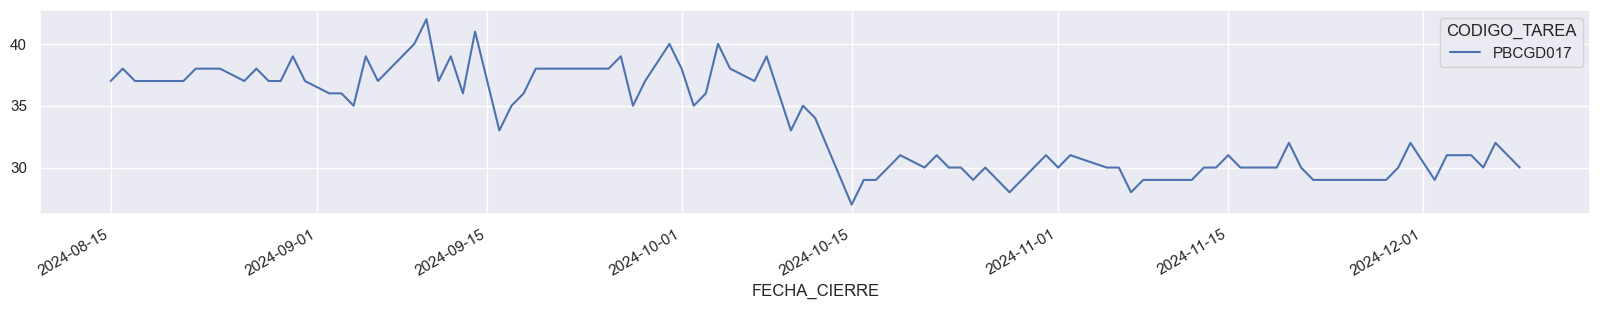

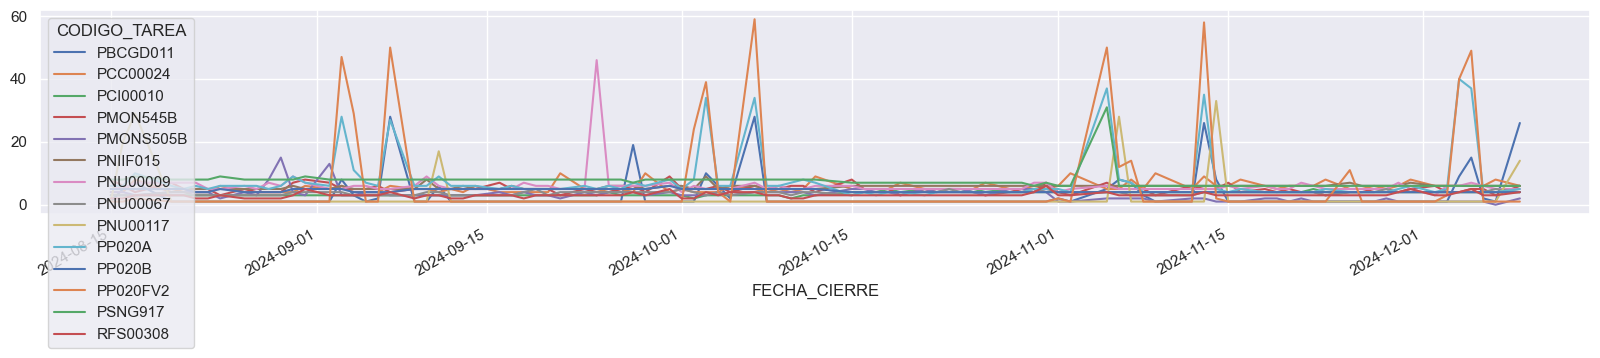

In [71]:
sns.set_theme(rc={'figure.figsize':(20,3)})
for grupo in range(7):
    if grupo  not in (1,):
        (df_crosstab_completo[df_crosstab_completo.GRUPO==grupo]).transpose().drop(index=["GRUPO"]).plot()


### NOTAS
- Con los modelos de agrupamiento no se logró identificar grupos de tareas que se tengan aumentos o disminuciones de duración el mismo día (correlacionadas).
- Las principales agrupaciones fueron entre proceso cuya duración son inferiores 6 minutoS.
- Se crean grupo individuales para las tareas que tienen máximos algunos días del mes, como:
```
PAHP900 	66 mins 1 vez en 3 meses
PP020FV2	60 mins 2 veces al mes
PP020A		60 mins 2 veces al mes
PBCGD011	60 mins 2 veces al mes
PPP92005	45.0	1 vez en los 3 meses
PB098100	40 o más 1 vez cada semana
PPP92005	45.0 una vez al mes

PNU00117    30 mins 2 veces al mes
PNU00217    30 mins 2 veces al mes

PBCGD017    por debajo de 40 mins hace un mes
```

In [72]:

lst_representativas = [
'PP020FV2',
'PP020A',
'PNU00117',
'PNU00217',
]


In [73]:

df_rep=df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_rep.set_index("FECHA_CIERRE", inplace=True)
df_rep.rename(columns={"DURACION_MIN":"REPRESENTATIVAS"},inplace=True)
df_sum2=df_sum.join(df_rep)


In [74]:
df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas)][["CODIGO_TAREA","DESCRIPCION_TAREA"]].value_counts()

CODIGO_TAREA  DESCRIPCION_TAREA             
PNU00117      Pasaje Resultados FVC             96
PNU00217      Pasaje Resultados M/E a M/N Ac    96
PP020A        Pasaje a Historico FSH015-16 *    96
PP020FV2      PASAJE A HISTORICOS DE MOVIMI     96
Name: count, dtype: int64

<Axes: xlabel='FECHA_CIERRE'>

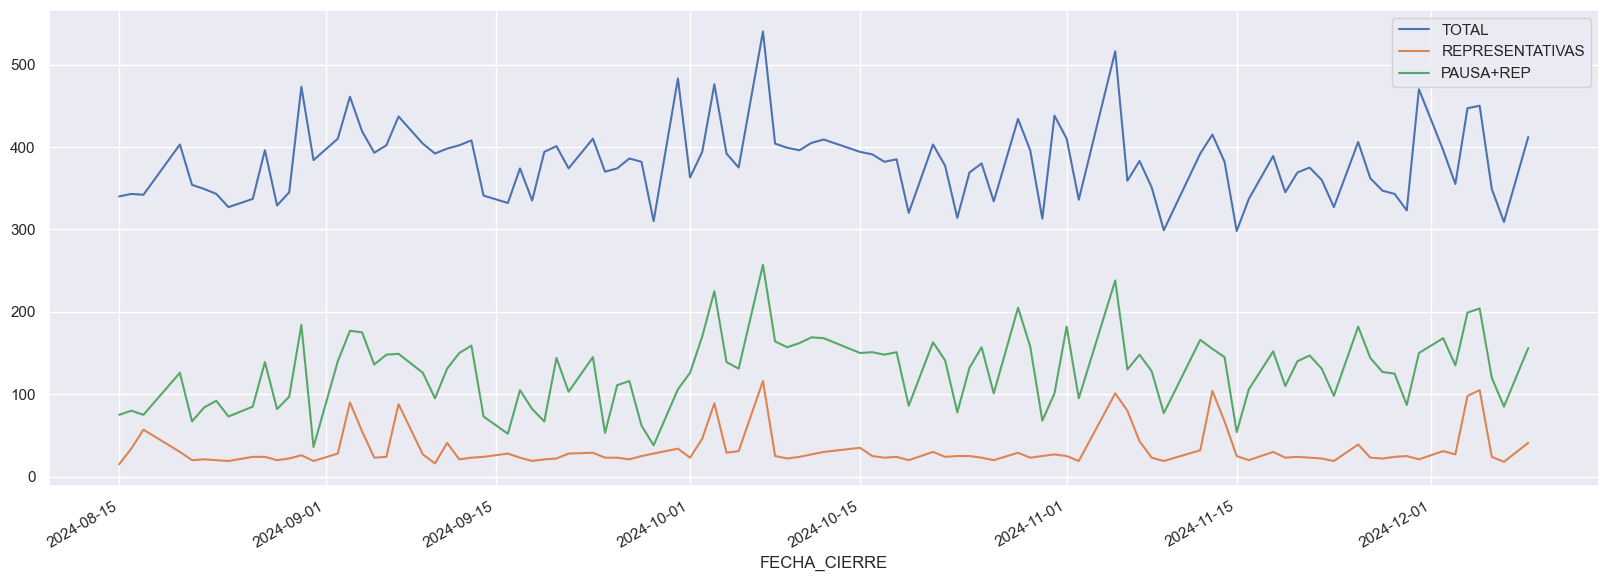

In [75]:
df_sum2["PAUSA+REP"]=df_sum2.DURACION_PAUSAS + df_sum2.REPRESENTATIVAS
df_sum2["PORCENTAJE"]=df_sum2["PAUSA+REP"]/df_sum2["TOTAL"]*100
df_sum2["DIF"]=df_sum2["TOTAL"]-df_sum2["PAUSA+REP"]

sns.set_theme(rc={'figure.figsize':(20,7)})
df_sum2[["TOTAL","REPRESENTATIVAS","PAUSA+REP",]].plot()


<Axes: xlabel='FECHA_CIERRE'>

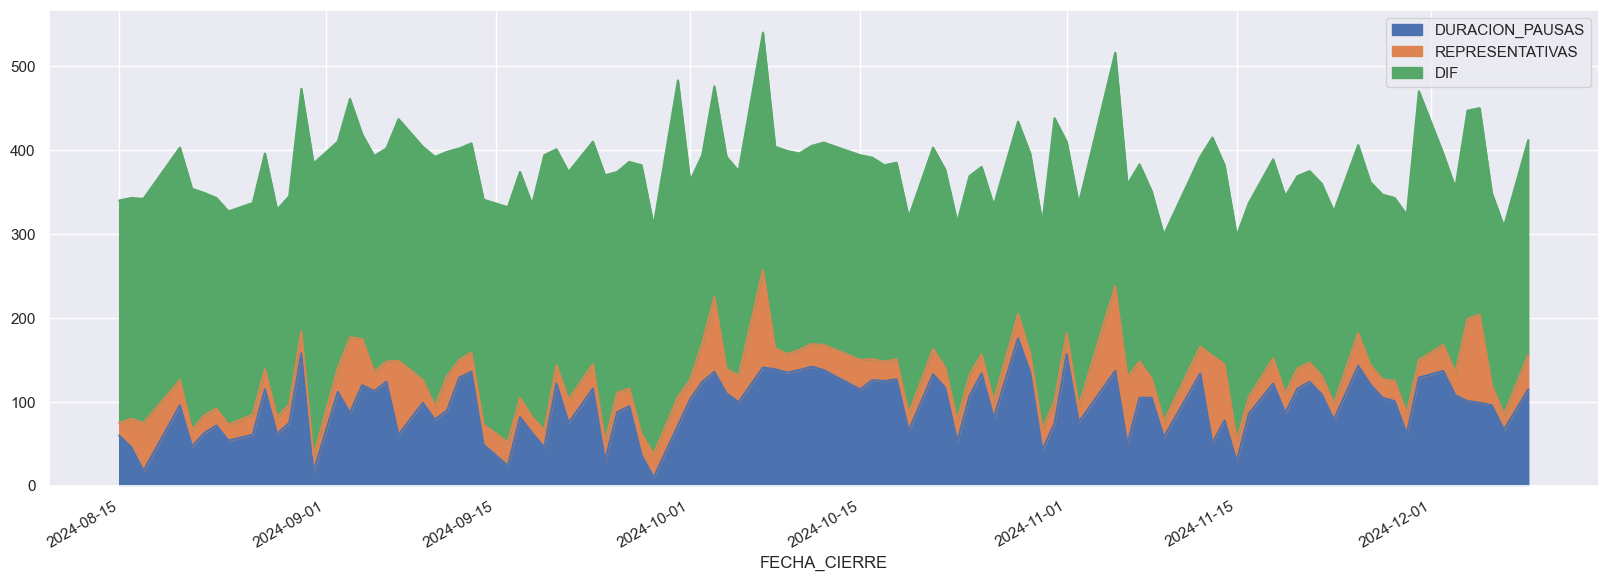

In [76]:
df_sum2[["DURACION_PAUSAS","REPRESENTATIVAS","DIF",]].plot.area()

In [77]:
df_sum2[["TOTAL","DURACION_PAUSAS","REPRESENTATIVAS","PAUSA+REP","PORCENTAJE","DIF"]]

TOTAL  DURACION_PAUSAS  REPRESENTATIVAS  PAUSA+REP  PORCENTAJE  \
FECHA_CIERRE                                                                   
2024-08-15    340.0             60.0             15.0       75.0   22.058824   
2024-08-16    343.0             46.0             34.0       80.0   23.323615   
2024-08-17    342.0             18.0             57.0       75.0   21.929825   
2024-08-20    403.0             96.0             30.0      126.0   31.265509   
2024-08-21    354.0             47.0             20.0       67.0   18.926554   
...             ...              ...              ...        ...         ...   
2024-12-04    447.0            101.0             98.0      199.0   44.519016   
2024-12-05    450.0             99.0            105.0      204.0   45.333333   
2024-12-06    349.0             96.0             24.0      120.0   34.383954   
2024-12-07    309.0             67.0             18.0       85.0   27.508091   
2024-12-09    412.0            115.0             41.0      156.0   37.864078   

                DIF  
FECHA_CIERRE         
2024-08-15    265.0  
2024-08-16    263.0  
2024-08-17    267.0  
2024-08-20    277.0  
2024-08-21    287.0  
...             ...  
2024-12-04    248.0  
2024-12-05    246.0  
2024-12-06    229.0  
2024-12-07    224.0  
2024-12-09    256.0  

[96 rows x 6 columns]

<Axes: xlabel='FECHA_CIERRE'>

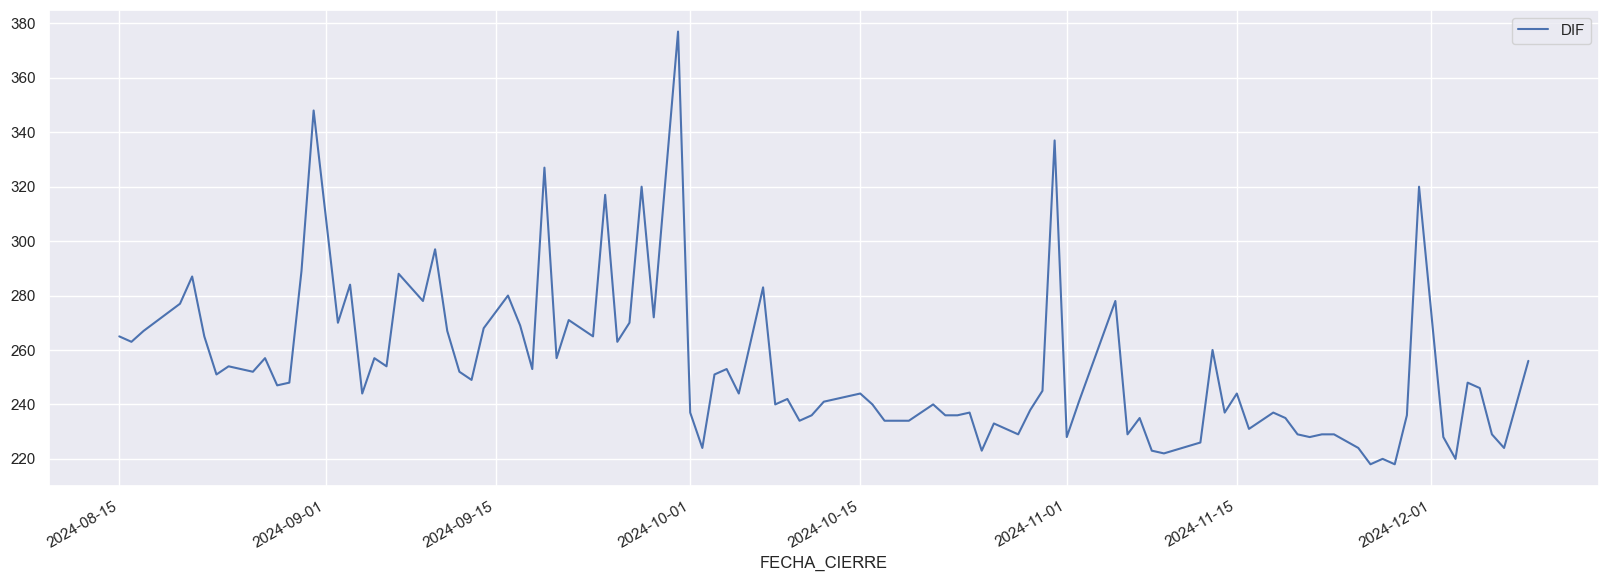

In [78]:
df_sum2[["DIF"]].plot()

### Importancia de tareas

In [79]:
df_regressor = pd.crosstab( df_parcial['FECHA_CIERRE'], df_parcial['CODIGO_TAREA'], values=df['DURACION_SEGUNDOS'], aggfunc='sum').reset_index()
df_regressor.fillna(0,inplace=True) 
df_regressor.loc[:,"TOTAL"]=df_regressor[df_regressor.columns[1:]].sum(axis=1,)


In [80]:
from sklearn.ensemble import GradientBoostingRegressor

y_train= df_regressor["TOTAL"]
X_train= df_regressor[df_regressor.columns[1:-1]]
# Entrenamiento
model_xgb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train, y_train)

# Importancia de características
importancias = model_xgb.feature_importances_

        Tarea  Importancia
3       PAUSA     0.291198
105    PP020A     0.244506
108  PP020FV2     0.089900
150  RFS00308     0.072887
68   PMON515D     0.039948
85   PNIIF015     0.036549
88   PNIIF019     0.026328
104     PP017     0.020887
39   PDECO030     0.013478
45   PDP00004     0.011257


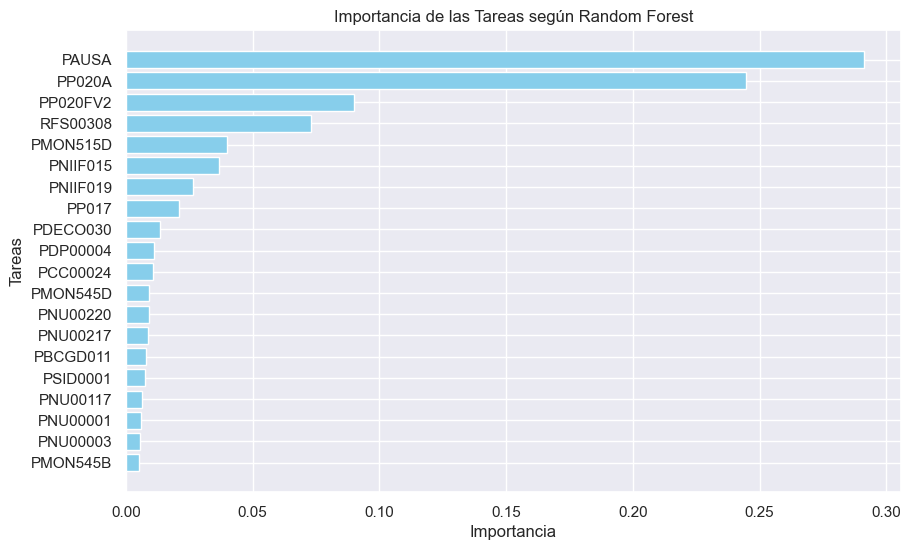

In [81]:
importancia_tareas = pd.DataFrame({
    'Tarea': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar las tareas más importantes
print(importancia_tareas.head(10))

# Graficar la importancia
plt.figure(figsize=(10, 6))
plt.barh(importancia_tareas.head(20)['Tarea'], importancia_tareas.head(20)['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Tareas')
plt.title('Importancia de las Tareas según Random Forest')
plt.gca().invert_yaxis()  # Invertir el eje Y para que las más importantes estén arriba
plt.show()

In [82]:

lst_representativas2 = [
'PP020FV2',
'PP020A',
'RFS00308',
'PP017',
'PNU00009',
'PNIIF015',
'PNU00001'
]


In [83]:
df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas2)][["CODIGO_TAREA","DESCRIPCION_TAREA"]].value_counts()

CODIGO_TAREA  DESCRIPCION_TAREA             
PNU00001      Pasaje de rubros                  100
PNIIF015      Copia Clientes y Sucursales de     96
PNU00009      Ajuste de Operaciones Cancelad     96
PP017         Depurador                          96
PP020A        Pasaje a Historico FSH015-16 *     96
PP020FV2      PASAJE A HISTORICOS DE MOVIMI      96
RFS00308      Lista Asientos F.Valor Contabl     96
Name: count, dtype: int64

In [84]:

df_rep2=df_parcial[df_parcial.CODIGO_TAREA.isin(lst_representativas2)].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_rep2.set_index("FECHA_CIERRE", inplace=True)
df_rep2.rename(columns={"DURACION_MIN":"REPRESENTATIVAS"},inplace=True)
df_sum3=df_sum.join(df_rep2)


<Axes: xlabel='FECHA_CIERRE'>

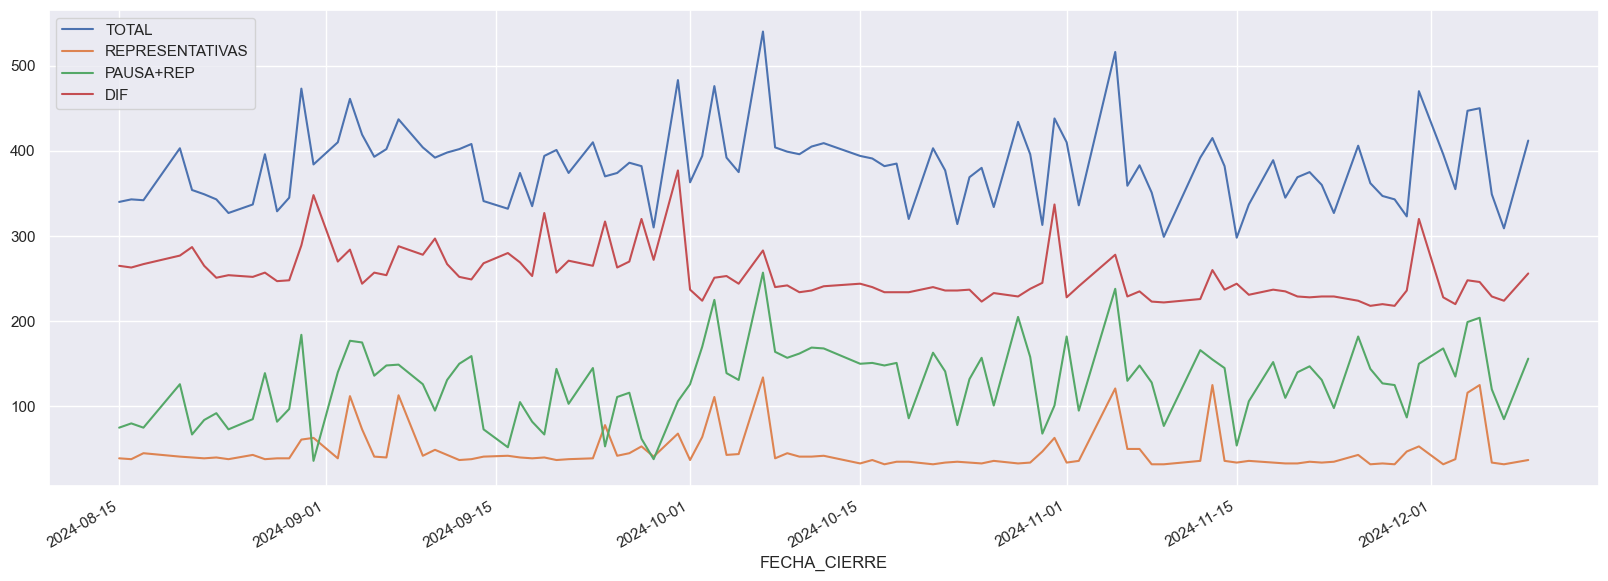

In [85]:
df_sum3["PAUSA+REP"]=df_sum3.DURACION_PAUSAS + df_sum2.REPRESENTATIVAS
df_sum3["PORCENTAJE"]=df_sum3["PAUSA+REP"]/df_sum3["TOTAL"]*100
df_sum3["DIF"]=df_sum3["TOTAL"]-df_sum3["PAUSA+REP"]

sns.set_theme(rc={'figure.figsize':(20,7)})
df_sum3[["TOTAL","REPRESENTATIVAS","PAUSA+REP","DIF"]].plot()


<Axes: xlabel='FECHA_CIERRE'>

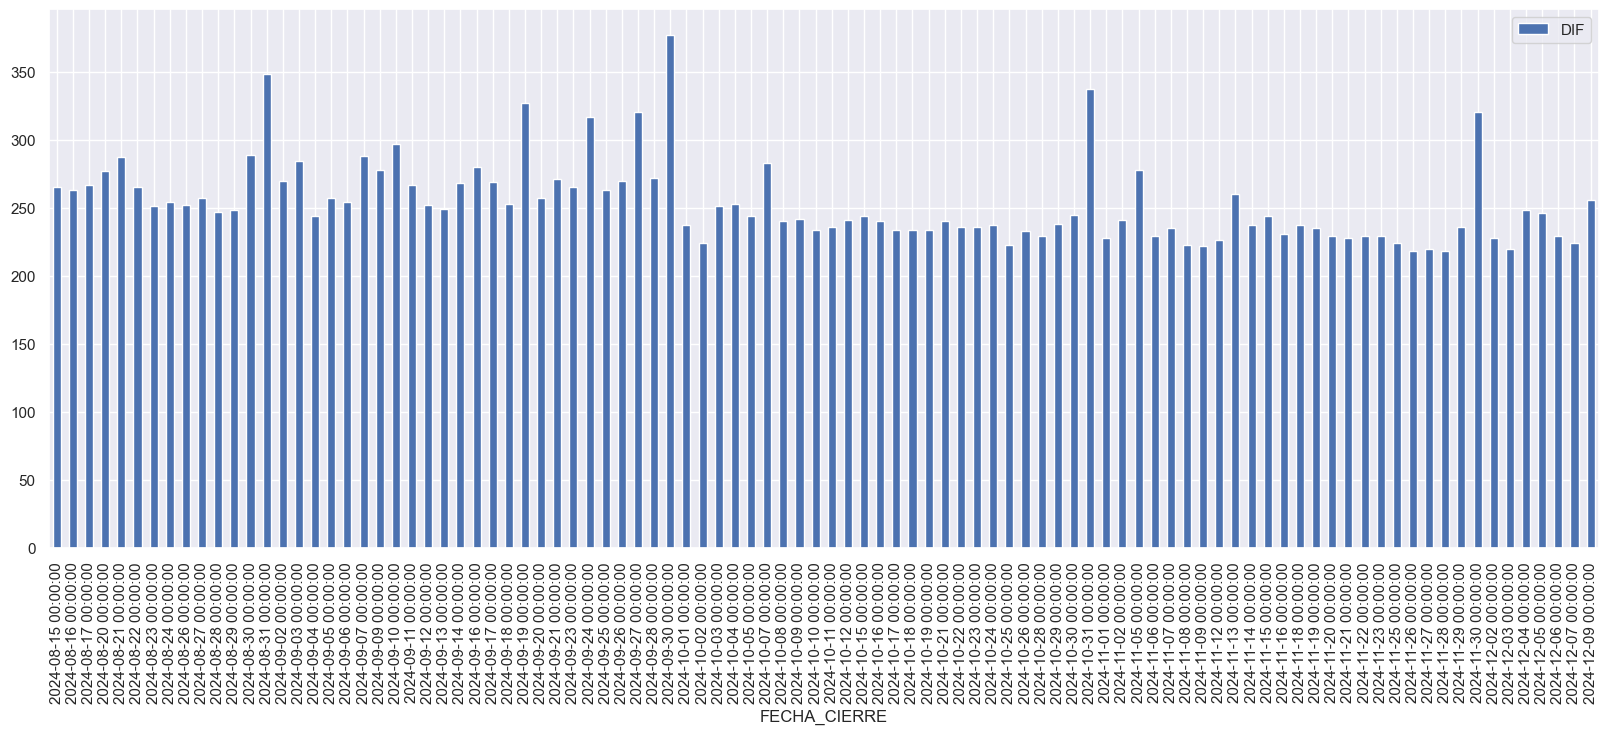

In [86]:
df_sum3[["DIF"]].plot.bar()

### Tareas que generaron el aumento el 31 de Octubre

In [87]:
lst_oct31=df_parcial[["CODIGO_TAREA","DESCRIPCION_TAREA","DURACION_SEGUNDOS"]][df_parcial.FECHA_CIERRE==pd.to_datetime(date(2024,10,31))].sort_values("DURACION_SEGUNDOS",ascending=False).head(10)['CODIGO_TAREA'].to_list()

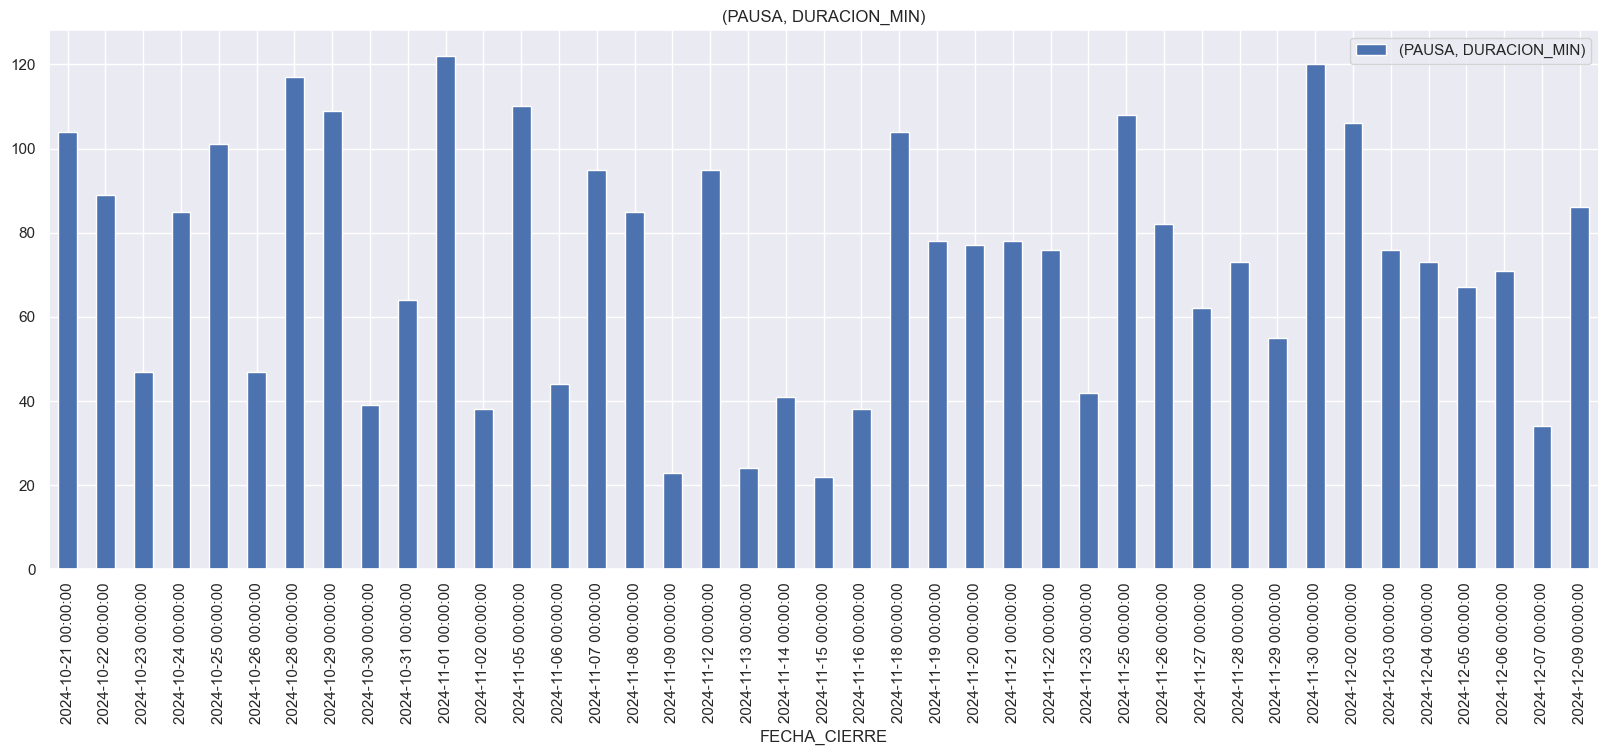

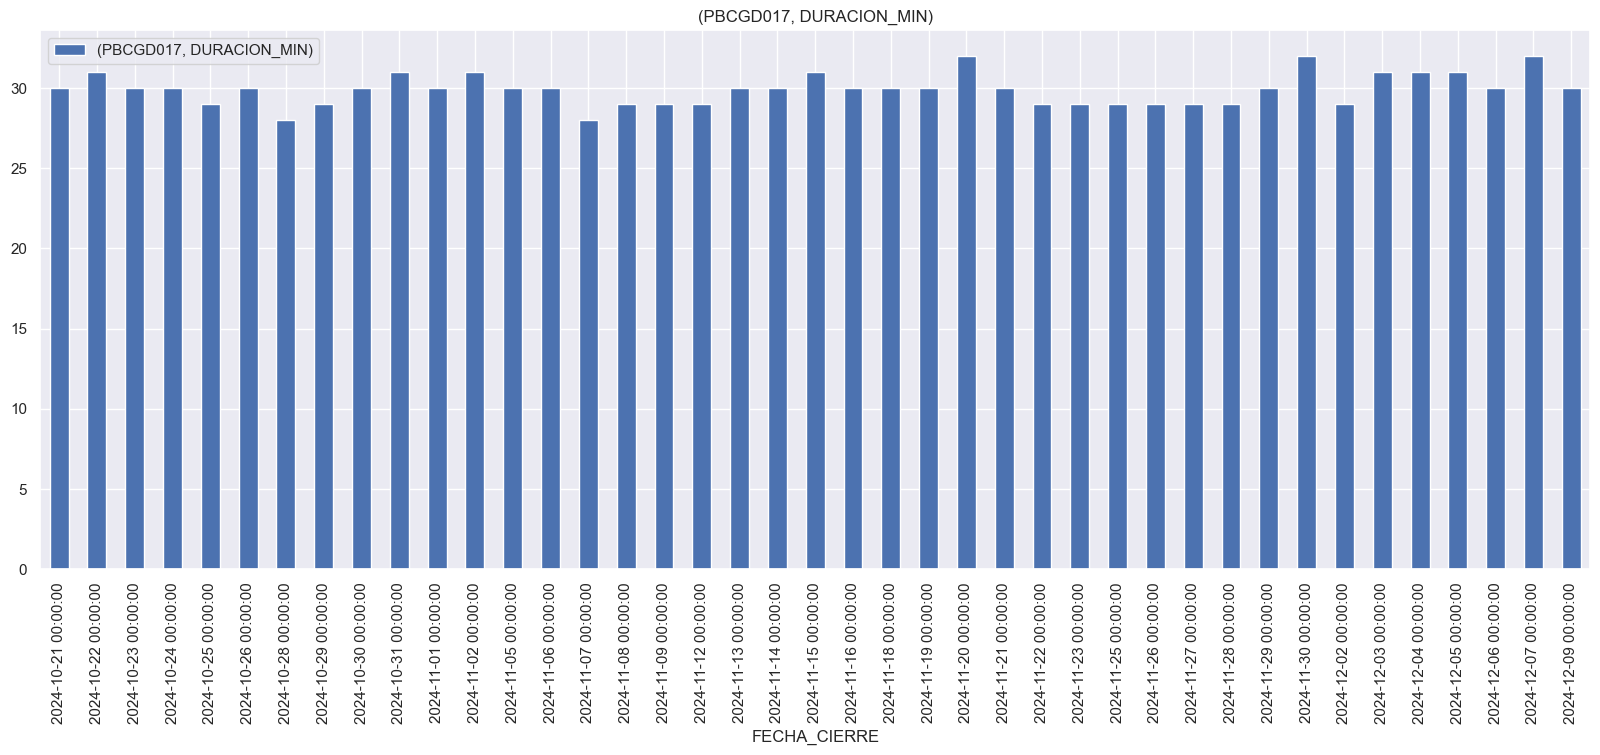

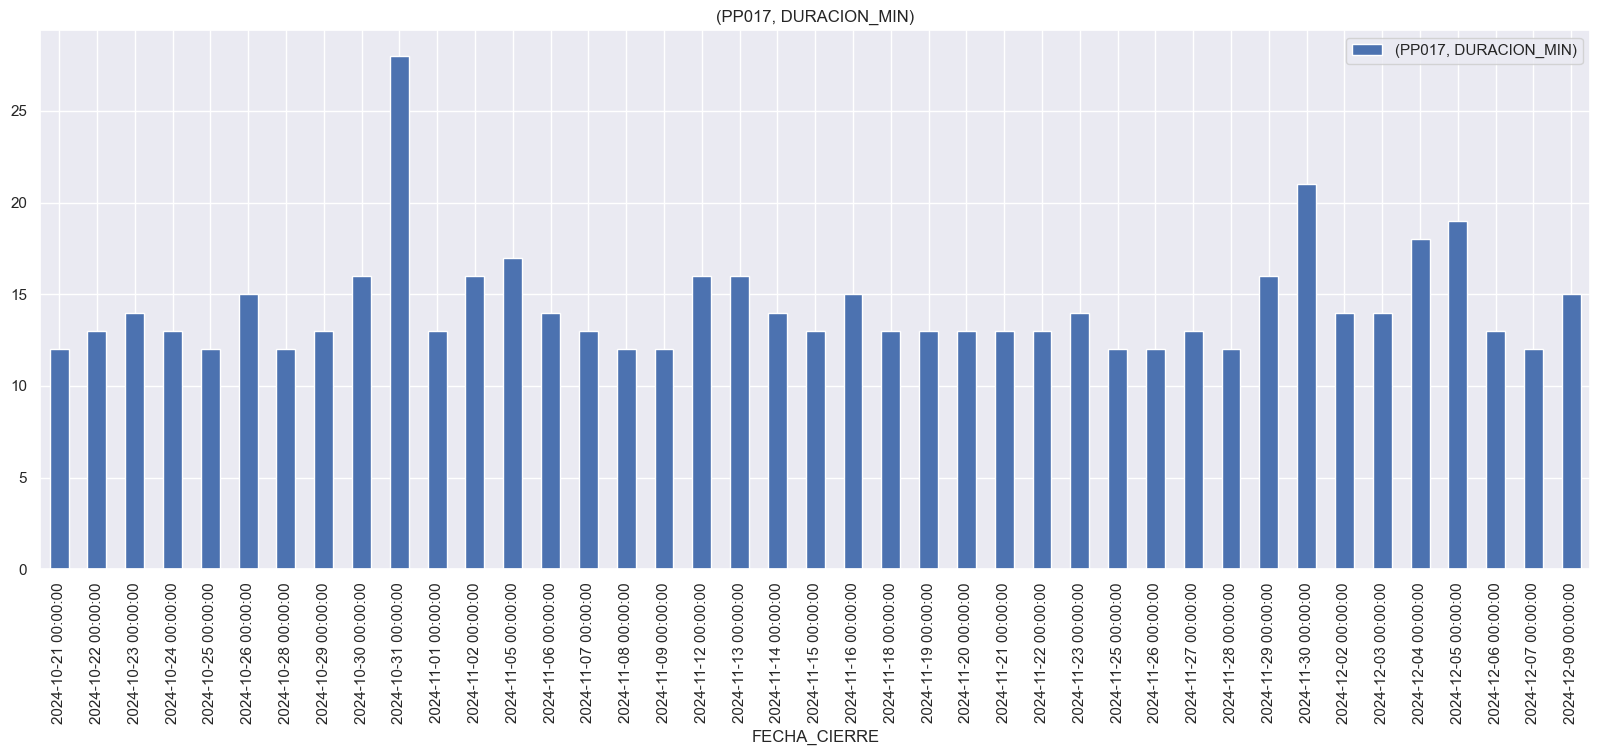

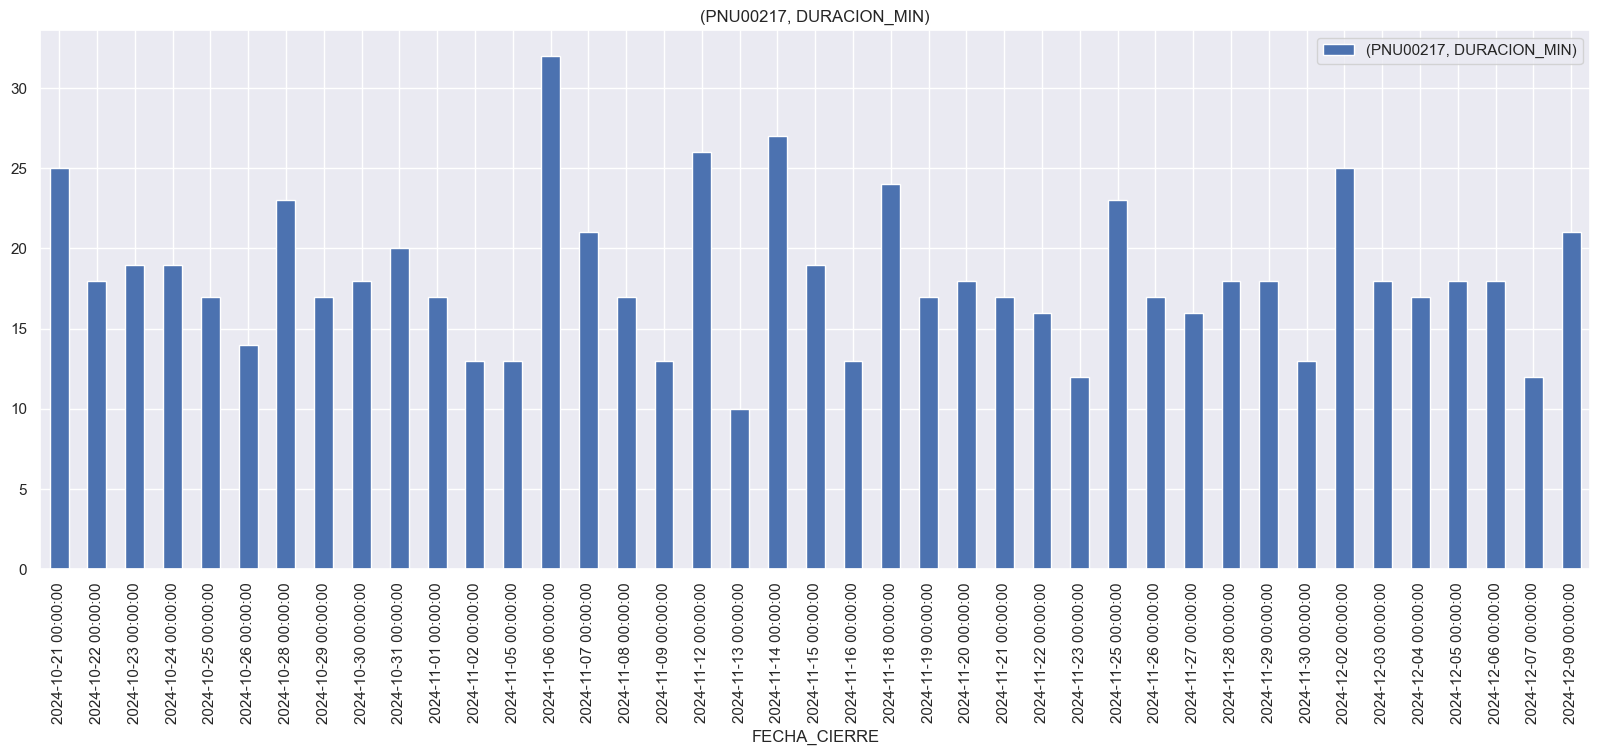

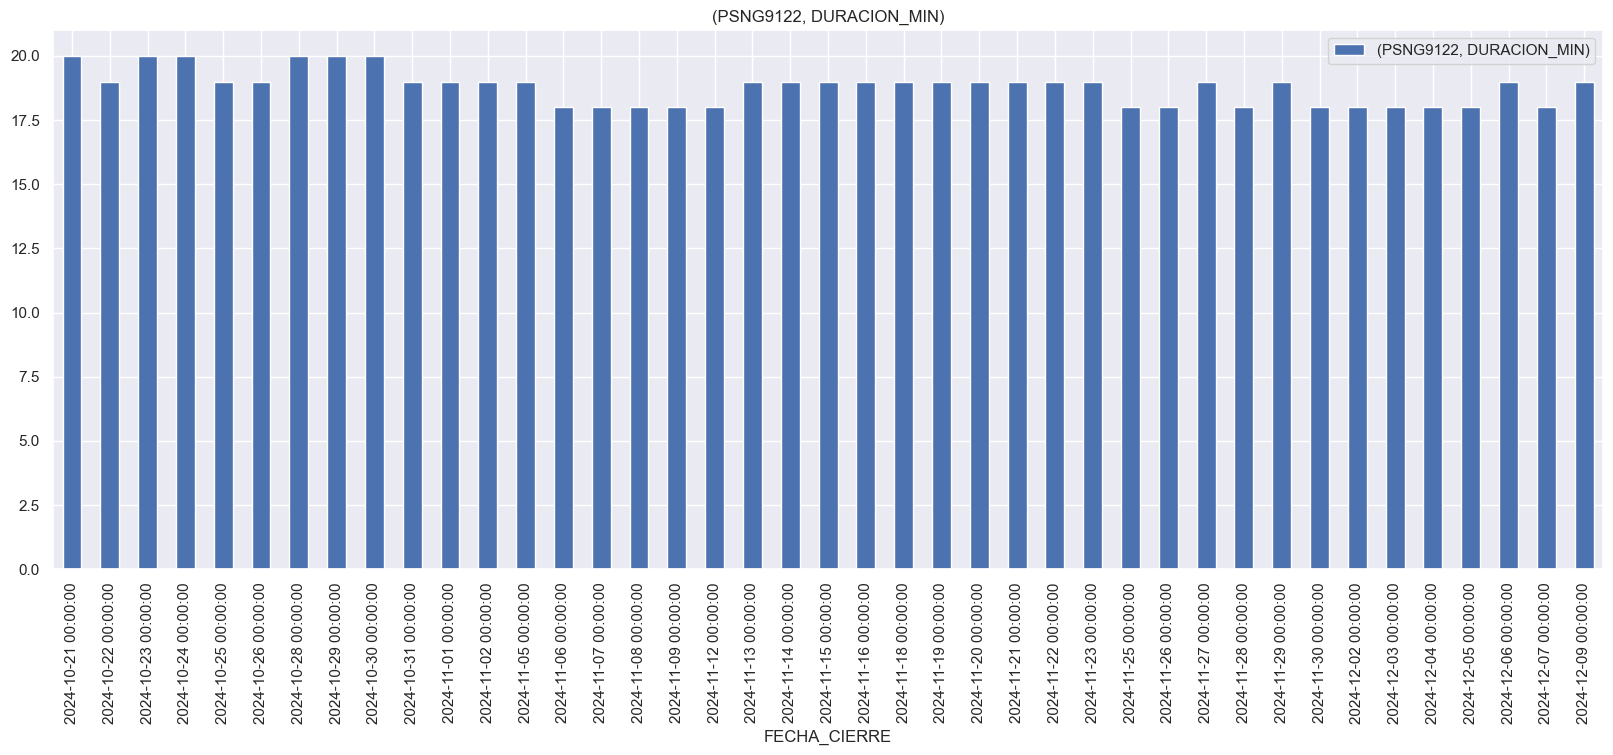

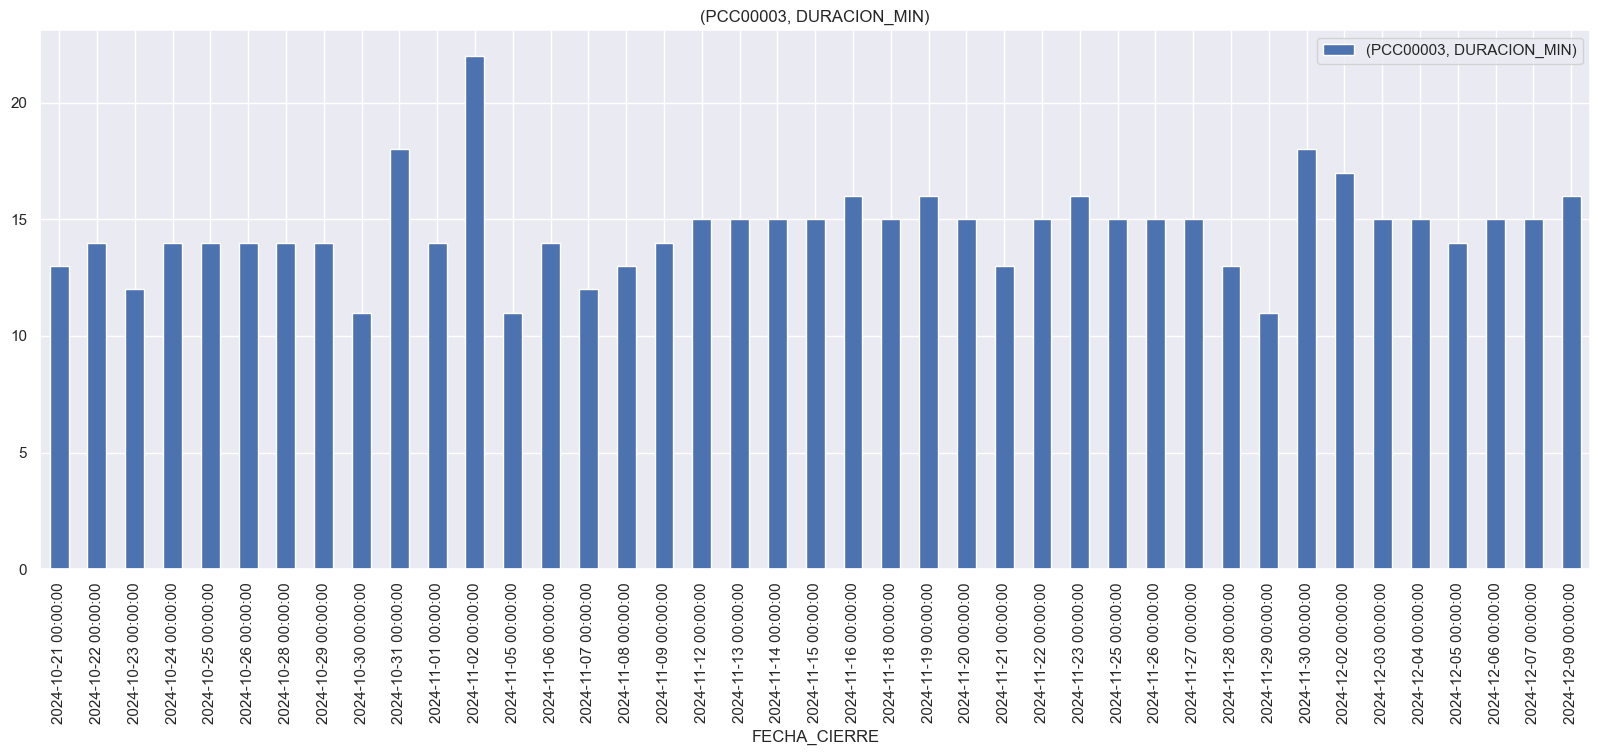

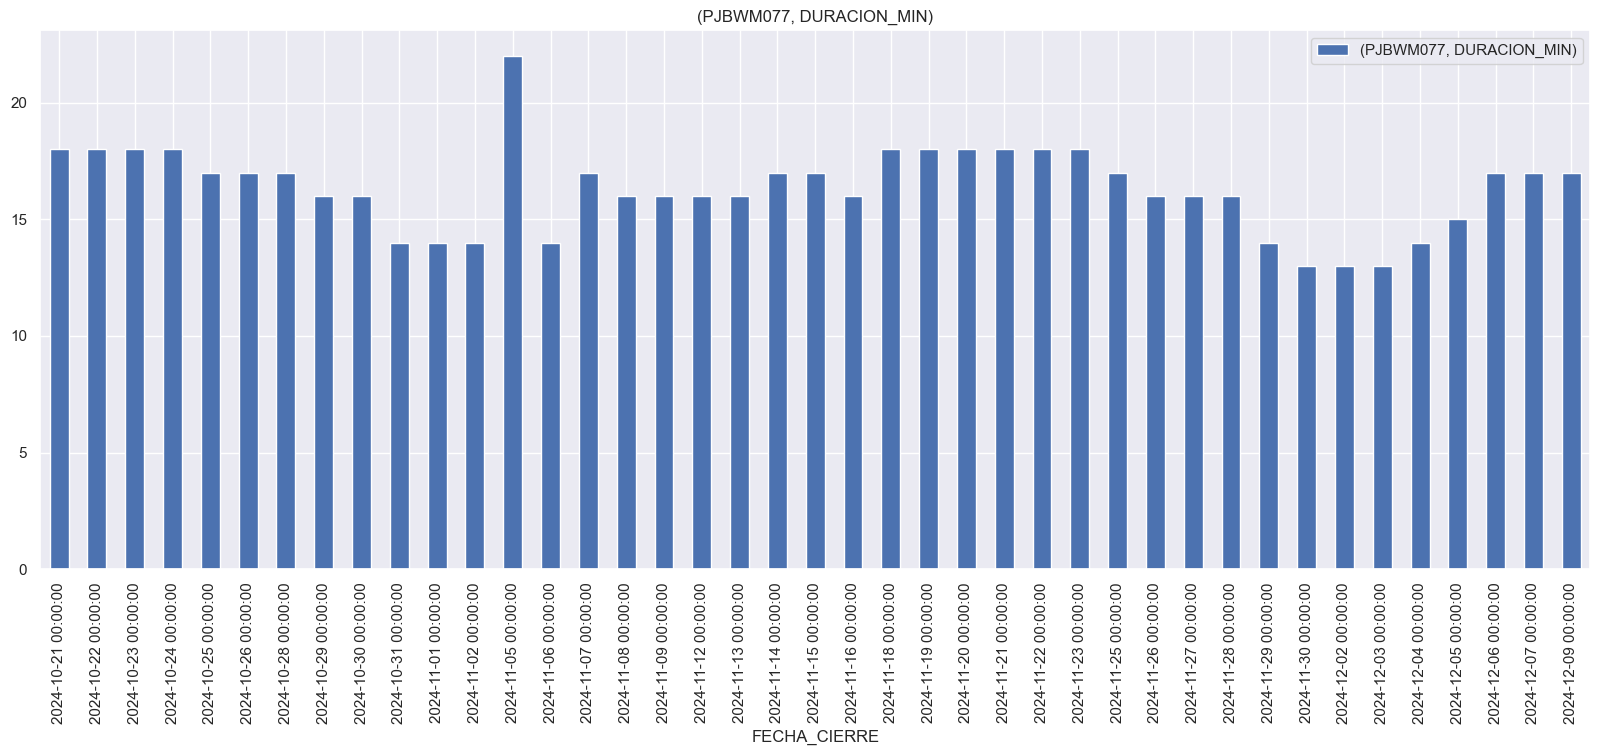

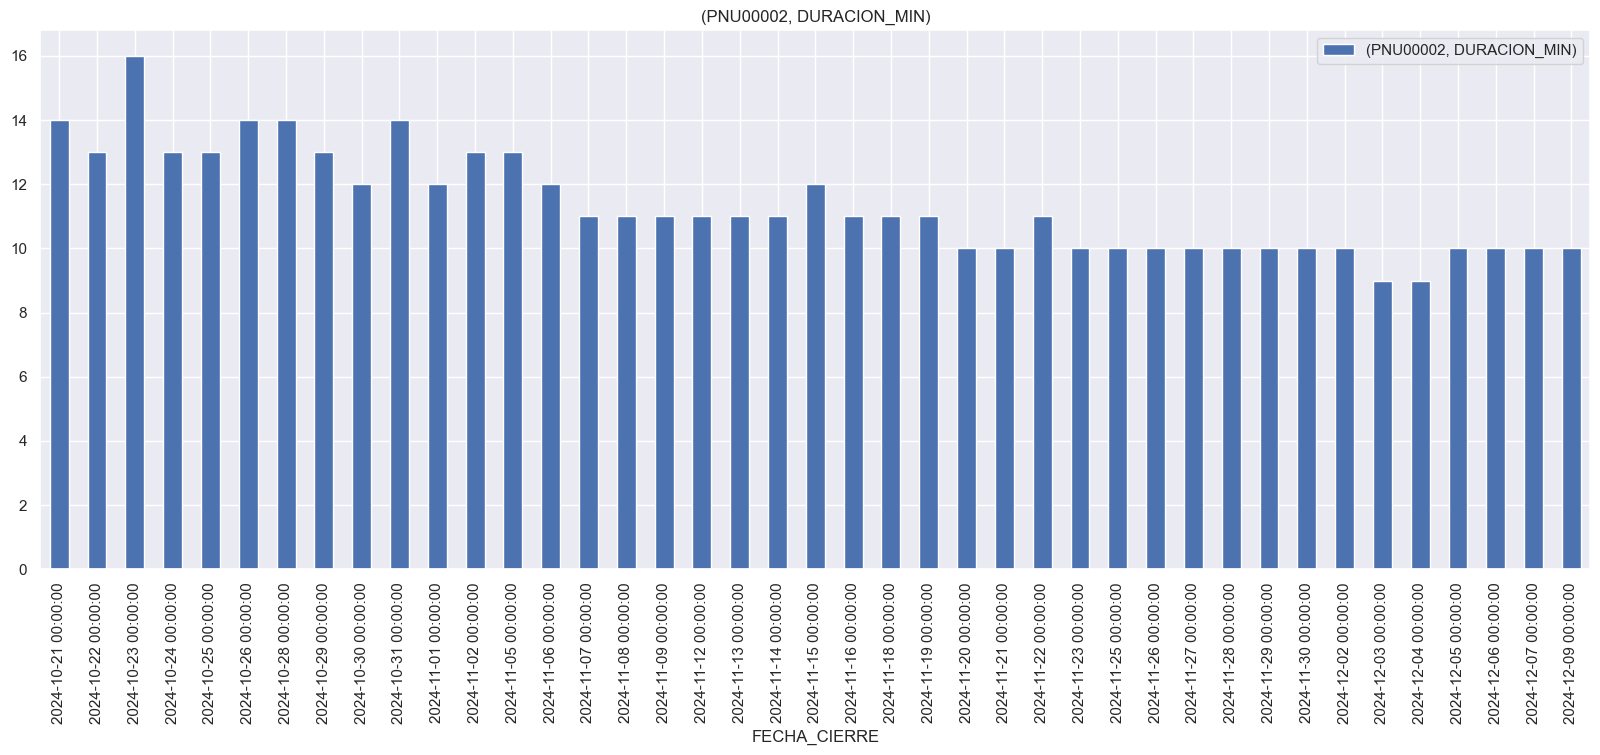

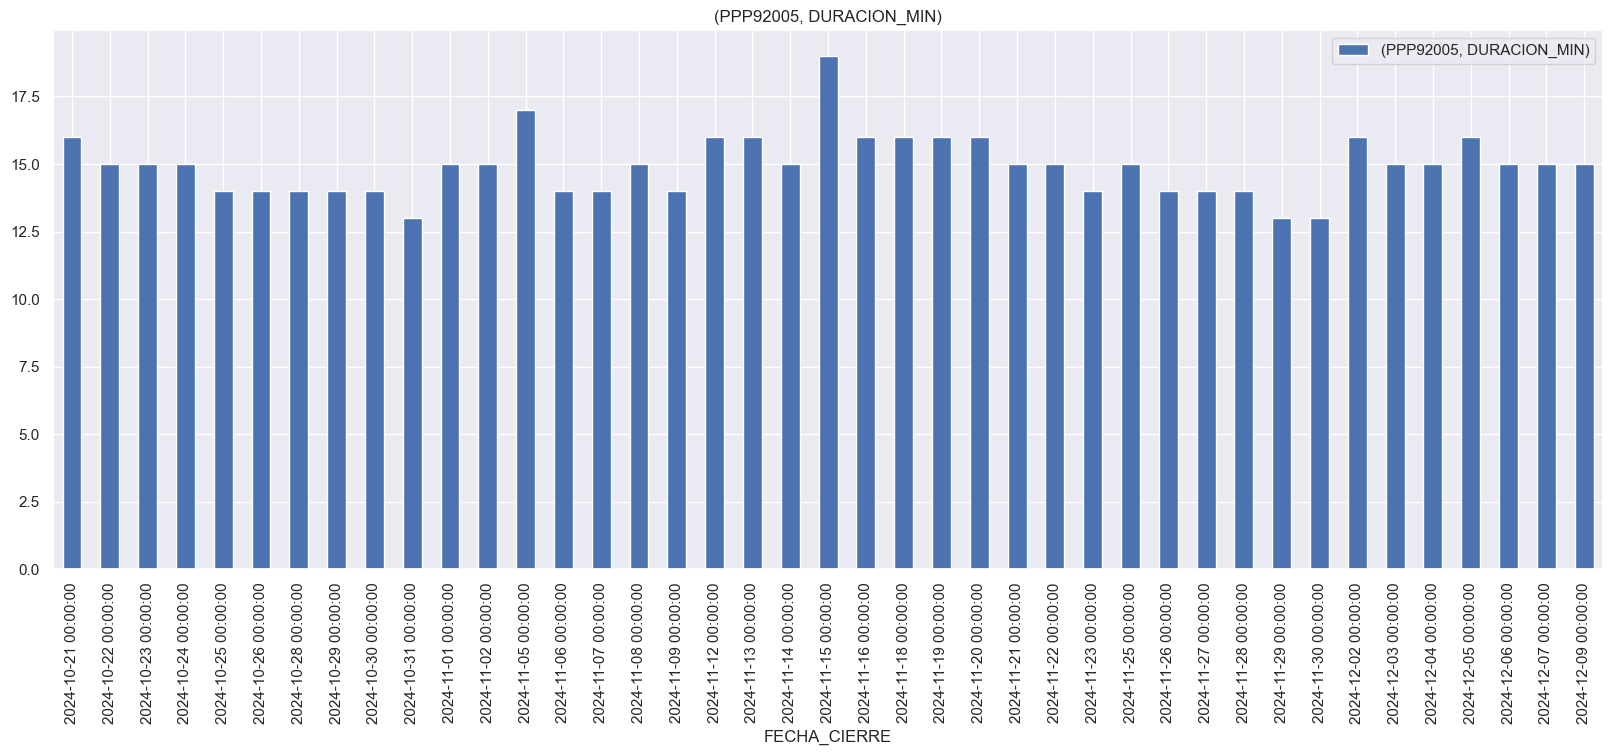

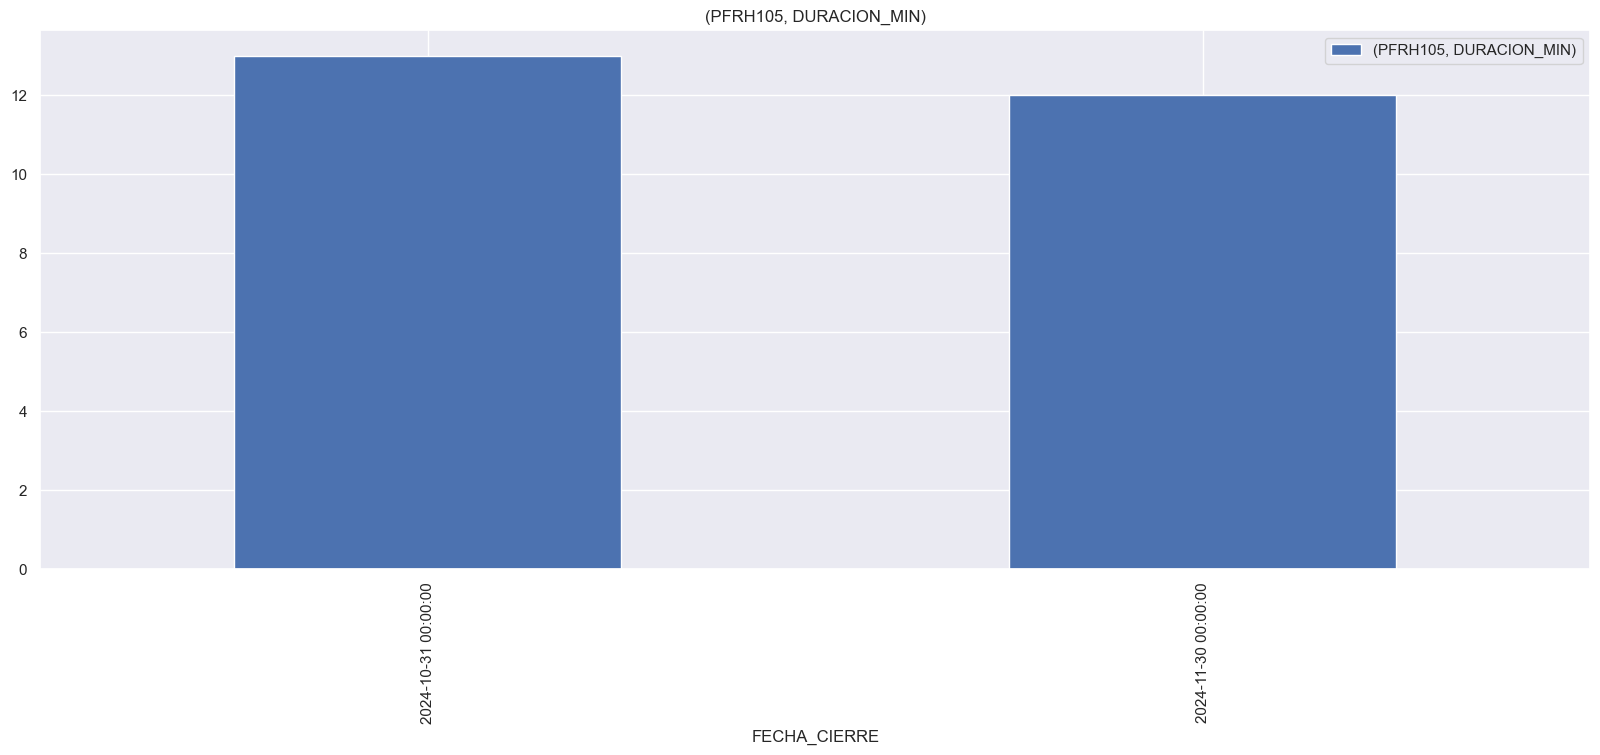

In [88]:
for tarea in lst_oct31:
    #df_parcial[df_parcial.CODIGO_TAREA==tarea].groupby(["FECHA_CIERRE",],).max()[["CODIGO_TAREA","DURACION_MIN"]].plot.bar(by="CODIGO_TAREA")
    df_parcial.query(f"CODIGO_TAREA=='{tarea}' & FECHA_CIERRE> '2024-10-20'").groupby(["FECHA_CIERRE",],).max()[["CODIGO_TAREA","DURACION_MIN"]].plot.bar(by="CODIGO_TAREA")

## Cantidad de tareas por fecha

<Axes: xlabel='FECHA_CIERRE'>

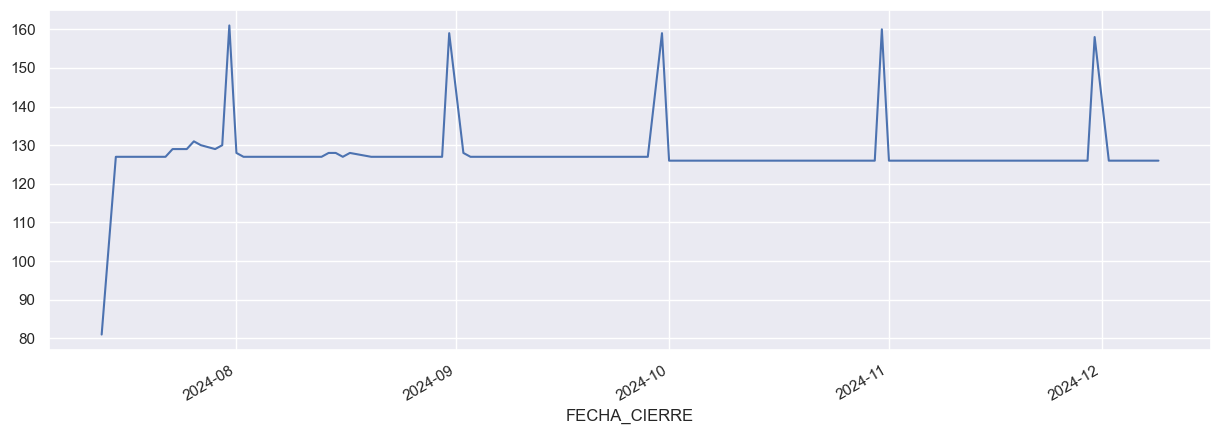

In [89]:
sns.set_theme(rc={'figure.figsize':(15,5)})
df.groupby(["FECHA_CIERRE"]).size().plot()

In [ ]:
# Ordenar por FECHA y hora de inicio\n
df_parcial2 = df_parcial.sort_values(by=['FECHA_CIERRE', 'INICIO'])
    
# Calcular el orden de ejecución de las tareas
df_parcial2['ORDEN'] = df.groupby('FECHA_CIERRE').cumcount() + 1
    
# Calcular la duración acumulada por fecha
df_parcial2['ACUMULADO_MIN'] = df.groupby('FECHA_CIERRE')['DURACION_MIN'].cumsum()
  
# Calcular el total de tareas y tiempo total de ejecución por fecha
df_totales = df_parcial2.groupby('FECHA_CIERRE').agg(
    TOTAL_TAREAS=('CODIGO_TAREA', 'count'),
    TIEMPO_TOTAL_MIN=('DURACION_MIN', 'sum')
).reset_index()
    
# Combinar los totales con el DataFrame original
df_parcial2 = df_parcial2.merge(df_totales, on='FECHA_CIERRE')


In [92]:

df_parcial2[['CODIGO_TAREA','DESCRIPCION_TAREA','DURACION_MIN','ORDEN','TOTAL_TAREAS','ACUMULADO_MIN','TIEMPO_TOTAL_MIN']][df_parcial2.CODIGO_TAREA.isin(lst_representativas+['PAUSA'])].groupby(['CODIGO_TAREA','DESCRIPCION_TAREA']).max().sort_values(by='ORDEN')

KeyError: "['TOTAL_TAREAS'] not in index"